# PPR Crime Report Notebook

## Setting Up

Before running the code below, make sure that you have the feature you created in the analysis Notebook - ``PPR_Crime_5ft`` - loaded into your ArcGIS Pro project.

You also want to <b>make sure that your new project folder is set up exactly like the example 2021 one</b> used in this code. The organization of folders is important to keep track of all the graphs and tables that are being produced.

There are numerous times throughout the code where you will have to change a path or layer name. These instances have red, bolded instructions that come just before the cell you need to change. If you are ever unsure of what line within the cell the instructions are referencing, there is also a ``#CHANGE!`` note after the line that needs to be changed.

### Import libraries and set environment

The cell below imports the necessary libraries - in this case, we need pandas, a common open-source library for table and summary manipulation, the Operating System library, numpy (for statistics), ArcGIS for Python API, and ArcPy. This cell will need to be re-run every time you re-open the Notebook in order for the code to work.

In [1]:
# The import statements load each module
import pandas as pd
import os
import numpy as np

import arcgis
import arcpy # Best practice: Load arcpy last to maintain priority for namespace

In [2]:
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps('Map')[0] # first map in project - mine is titled "Map"

<b><font color='red'>IMPORTANT: CHANGE THE SECOND LINE BELOW TO THE CURRENT YEAR'S PROJECT FOLDER. 

YOU MUST KEEP THE FORWARD SLASHES ( / ), EVEN IF PASTING THE FOLDER PATH.</font></b>

In [12]:
from pathlib import Path
path = Path("C:/Users/HP/Desktop/CrimeReport_Share/ExportFolder") #CHANGE!
print(path.absolute())

C:\Users\HP\Desktop\CrimeReport_Share\ExportFolder


### Add new Council District field for more accurate sorting

Since our council district field is currently a text/string field and therefore will be sorted using a lexicographic sorting method (10 comes before 2 because 1 is the first character), we're going to add an integer council district field to make our manipulation of charts and graphs a bit easier below. 

<b>You only need to run this once, even if you are re-opening your Notebook and running every other cell again. Once the feature has this field added and populated, you cannot do it again.</b>

In [ ]:
arcpy.management.AddField("PPR_Crime_5ft", "COUNCILDIS", "SHORT", 5)

In [ ]:
inTable = "PPR_Crime_5ft"
fieldName = "COUNCILDIS"
expression = "!COUNCIL_DISTRICT!"
arcpy.CalculateField_management(inTable, fieldName, expression, "PYTHON")

You can check the layer to make sure that this field has been added.

### Convert ``PPR_Crime_5ft`` to spatial dataframe for quicker manipulation

Our crime report filters our sites down further than the crime analysis did. We only want program sites, so we're going to set a definition query to include only program sites in our report.

In [13]:
# set definition query for only program sites
for lyr in mp.listLayers("PPR_Crime_5ft"):
    lyr.definitionQuery = "PROGRAM_SITES = 'Y'"

To manipulate our data using the <a href="https://pandas.pydata.org/about/">pandas</a> library, we need to convert our feature into a spatial dataframe.

In [14]:
sdf = pd.DataFrame.spatial.from_featureclass("PPR_Crime_5ft")
sdf.shape # to find number of rows and columns

(290, 60)

Add an incident count column per PPR property (based on public name to avoid duplicates) - this is like summarizing our data in a separate table, but we're including it in our existing dataframe instead. We're counting the number of crime point incidents for each PPR property.

In [16]:
# summarize incident count
sdf['incident_count'] = sdf.groupby('PUBLIC_NAM')['PUBLIC_NAM'].transform('count')

Let's visualize the first 5 rows of our dataframe to make sure it aligns with the feature's attribute table. We should see an accurate count of crimes per property in the last column of the dataframe.

In [17]:
sdf.head(5)

,FID,Join_Count,TARGET_FID,JOIN_FID,DC_DIST,PSA,DISPATCH_D,DISPATCH_1,DISPATCH_T,HOUR_,DC_KEY,LOCATION_B,UCR_GENERA,TEXT_GENER,POINT_X,POINT_Y,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOU,PUBLIC_NAM,PARENT_NAM,NESTED,OFFICIAL_N,OFFICIAL_1,LABEL,ALIAS,DPP_ASSET_,ADDRESS_91,ZIP_CODE,ADDRESS_BR,ALIAS_ADDR,ACREAGE,PROPERTY_C,PPR_USE,MAINTENANC,LAND_OWNER,TENANT,ACQUISITIO,FORMER_DEP,PPR_DISTRI,PPR_OPS_DI,COUNCIL_DI,POLICE_DIS,PROGRAM_SI,PUBLIC_MAP,PUBLIC_BIG,INTERNAL_B,TPL_LAND_C,CRIME_ANAL,COMMENTS,GIS_CHRONO,DATE_EDITE,EDITED_BY,NOTES,BUFF_DIST,ORIG_FID,COUNCILDIS,COUNCILD_1,SHAPE,incident_count
0,0,1,2,7,25,1,2021-01-21,2021-01-21,02:29:53,2,202125004181,1000 BLOCK W HUNTING PARK AVE,300,Robbery Firearm,-75.142065,40.016189,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698860.0264106393, ""y"": 259536.79384239...",26
1,1,1,5,163,16,2,2021-01-08,2021-01-08,22:15:00,22,202116000905,500 BLOCK N PAXON ST,2600,All Other Offenses,-75.223861,39.968329,Part 2 Crime,All Other Offenses,Off-Season,Active,West Mill Creek,West Mill Creek,N,West Mill Creek,Communications (2019),West Mill Creek,,1970,5100 WESTMINSTER AVE,19139,"525-53 N 52ND ST,5127-41&5100 WESTMINSTER AVE,...","51st & Reno;525-53 N 52ND ST,5127-41&5100 WEST...",5.244066,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,PRA,PPR,,REC,8,8,3,16,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-02-16,PARK_C,Feature Redesign Part 1,5.0,176,3,3,"{""x"": 2676457.876661226, ""y"": 241443.434359893...",37
2,2,1,6,7,25,1,2021-10-16,2021-10-16,19:44:00,19,202125063375,900 BLOCK W Hunting Park Ave,300,Robbery No Firearm,-75.141620,40.015934,Part 1 Violent Crime,Robbery,Off-Season,Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698987.418872386, ""y"": 259447.652616471...",26
3,3,1,7,7,25,1,2021-09-07,2021-09-07,04:41:00,4,202125054507,1200 BLOCK W HUNTING PARK AV,600,Thefts,-75.144901,40.016559,Part 1 Property Crime,Theft,Off-Season,Non-Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71.100807,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,12,5,5,"{""x"": 2698062.052612886, ""y"": 259648.167963475...",26
4,4,1,9,184,15,1,2021-03-11,2021-03-11,15:41:58,15,202115017081,1000 BLOCK ARROTT ST,400,Aggravated Assault No Firearm,-75.092263,40.021487,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,Private Alfred J Simpson Memorial Recreation C...,Private Alfred J Simpson Memorial Recreation C...,N,Private Alfred J. Simpson Memorial Recreation ...,1953 - DF Research,Simpson,,1954,1010 ARROTT ST,19124,1010 ARROTT ST,Arrott & Large;1000 ARROTT ST,4.554142,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,CITY,,1949,REC,3,3,7,15,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5.0,197,7,7,"{""x"": 2712745.012092054, ""y"": 261881.767170816...",5


## Overview / Page 1 Tables and Charts

This section includes the code that creates our tables and charts for just the first page of the report. This page includes a <b>pivot table</b> to summarize crime counts by part and district, an <b>overall pie chart</b> showing crime part by count, and an <b>overall bar graph</b> showing crime count by council district.

### Center Pivot Table

We're using pandas to create a pivot table from our original ``sdf`` dataframe. This pivot table summarizes incident counts by crime type and district number. We format it using pandas and then save it to an HTML, which references a CSS stylesheet, to add colors, cell borders, font, and more. 

In [18]:
# get new df with only GIS Part by incident count - same as pg 1 upper-mid table
# format pivot table as first step
part_bycount = sdf.pivot_table(values='incident_count', index=['COUNCILDIS'],
                                     columns=['GIS_PART'], aggfunc='count')

part_bycount.index.names = ['District #'] # rename index column
part_bycount.columns.name = None # get rid of extra column name
part_bycount['Total Incidents'] = part_bycount.sum(axis=1) # get total incident column
part_bycount.loc["All Districts"] = part_bycount.sum() # get toal incident bottom row
 
part_bycount.head(11) # see all 11 rows

,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total Incidents
District #,,,,
1,17,10,12,39
2,11,3,19,33
3,3,4,34,41
4,7,7,15,29
5,17,13,13,43
6,3,3,4,10
7,11,10,22,43
8,6,1,21,28
9,3,1,8,12


Our pivot table isn't perfect (would be great to merge those first two header rows and highlight max values), but now we can export it as an HTML table and style it as much as we can using our CSS style sheet that lives in the crime automation folder.

In [10]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/overviewpivot.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/OverviewPage/page1pivottable.html", 'w') as f: 
    f.write(html_string.format(table=part_bycount.to_html(classes='mystyle')))

Check the overview page folder within this year's annual stats folder for this table. It should be an HTML.

### Pie Chart

To create the overall crime pie chart, we first need a separate dataframe with only our counts per part.

In [11]:
page1pie = sdf.groupby('GIS_PART')['incident_count'].agg('count').reset_index()
page1pie.head(5)

,GIS_PART,incident_count
0,Part 1 Property Crime,82
1,Part 1 Violent Crime,54
2,Part 2 Crime,154


With our new dataframe, we can now create our pie chart for the first page (all crimes).

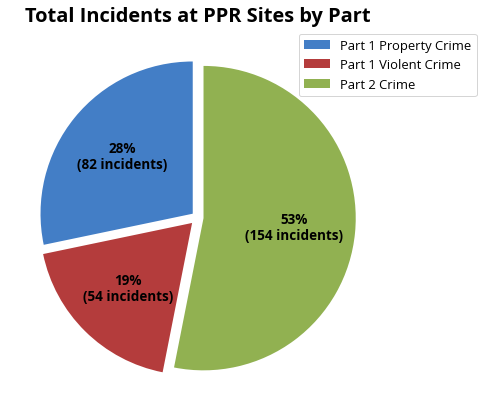

In [12]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"
    
# Creating color parameters
colors = ("#437EC6", "#B43C3C", "#91B151")
explode = 0.04, 0.05, 0.04 
 
# Wedge properties
wp = { 'linewidth' : 1}
 
# Creating autocpt arguments
def autopct_format(values):
    def my_format(pct):
        total=sum(values)
        val=int(round(pct*total/100.0))
        return '{:.0f}%\n({v:d} incidents)'.format(pct, v=val)
    return my_format # creates labels text - % and # of incidents
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7)) # how big your overall figure (around pie chart) is
wedges, texts, autotexts = ax.pie(page1pie['incident_count'], # value - crime count
                                  autopct = autopct_format(page1pie['incident_count']),
                                  explode = explode,
                                  colors = colors,
                                  # shadow = True, - turn on if you want drop shadow
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black")) # text color
 
# Adding legend
ax.legend(wedges, page1pie['GIS_PART'], prop={'size':13}, # last parameter is legend font size
          loc ="upper center", # text in legend
          bbox_to_anchor =(0.8, 0, 0.4, 1)) # where the legend is placed
 
plt.setp(autotexts, size = 13.5, weight ="bold") # labels
ax.set_title("Total Incidents at PPR Sites by Part", weight='bold', fontname='Open Sans', fontsize='20') # title
 
# show plot
fig.savefig(str(path) + "/OverviewPage/page1pie.png", dpi=300)

plt.show() # previews plot below

Check the overview page folder within this year's annual stats folder for this pie chart. It should be a PNG.

### Bar Graph

We're creating a new table with the same information as the pivot table for the bar graph. This table and graph show the number of incidents per part by council district.

In [13]:
bargraph = sdf.groupby(['COUNCILDIS', 'GIS_PART'])['incident_count'].count().reset_index()
bargraph.head(10)

,COUNCILDIS,GIS_PART,incident_count
0,1,Part 1 Property Crime,17
1,1,Part 1 Violent Crime,10
2,1,Part 2 Crime,12
3,2,Part 1 Property Crime,11
4,2,Part 1 Violent Crime,3
5,2,Part 2 Crime,19
6,3,Part 1 Property Crime,3
7,3,Part 1 Violent Crime,4
8,3,Part 2 Crime,34
9,4,Part 1 Property Crime,7


Using the table we just created above, we're going to build and style a bar graph of crime count by council district.

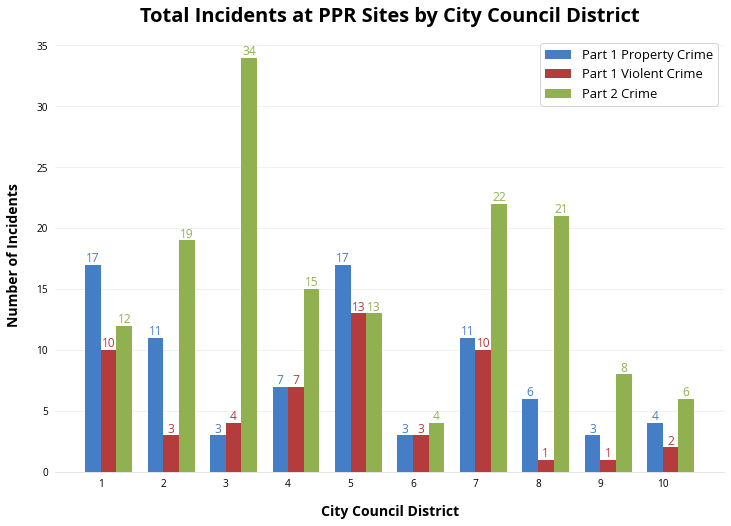

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots(figsize=(12, 8))

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our jobs.
x = np.arange(len(bargraph.COUNCILDIS.unique()))

# Define bar width. We need this to offset the second bar.
bar_width = 0.25

# Same thing, but offset the x.
b1 = ax.bar(x, bargraph.loc[bargraph['GIS_PART'] == 'Part 1 Property Crime', 'incident_count'],
            color='#437EC6', width=bar_width, label='Part 1 Property Crime')
b1 = ax.bar(x + bar_width, bargraph.loc[bargraph['GIS_PART'] == 'Part 1 Violent Crime', 'incident_count'],
            color='#B43C3C', width=bar_width, label='Part 1 Violent Crime')
b3 = ax.bar(x + bar_width + bar_width, bargraph.loc[bargraph['GIS_PART'] == 'Part 2 Crime', 'incident_count'],
            color='#91B151', width=bar_width, label='Part 2 Crime')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(bargraph.COUNCILDIS.unique())

# Add legend.
ax.legend(prop={'size':13})

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('City Council District', fontname='Open Sans', fontsize='14', weight='bold', labelpad=15)
ax.set_ylabel('Number of Incidents', fontname='Open Sans', fontsize='14', weight='bold', labelpad=15)
ax.set_title('Total Incidents at PPR Sites by City Council District', pad=15, weight='bold', fontname='Open Sans', fontsize='20')

# For each bar in the chart, add a text label.
for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)

fig.savefig(str(path) + "/OverviewPage/barchart", dpi=300)
plt.show()

Check the overview page folder within this year's annual stats folder for this graph. It should be a PNG.

## Summary Tables and Charts for Each District

We're now going to create our overview tables and pie charts as well as our individual site tables and pie charts. This section has a subsection for each of the ten City Council Districts, with each district subsection incluidng five subsections: 1) the district cover page summary analysis table, 2) the district cover page pivot table, 3) the district cover page pie chart, 4) the pie charts for each individual PPR site within the district, and 5) the 4 individual tables for each PPR site. 

### District 1

#### Main Summary Analysis Table

The main summary analysis table refers to the table at the top left of the crime report's district overview page. This table includes all site names that have had crimes occur for the entire district. It also includes the number of incidents per site, the type of each crime (``GIS_PART``) and the crime category (``GIS_CRIME``).

In [20]:
# filter original dataframe to see only District 1 sites
dis1f = sdf[sdf['COUNCILDIS'] == 1] 

# summarize incident count
dis1 = dis1f.groupby(['PUBLIC_NAM', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis1.pop('incident_count')
dis1.insert(1, 'incident_count', first_column) 

# rename columns
dis1.rename(columns = {'PUBLIC_NAM':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

# add a row at the bottom for total incidents
dis1 = dis1.append(dis1.sum(numeric_only=True), ignore_index=True)
dis1['Site Name'].fillna('Total Incidents in District', inplace=True)

# fill in NAs and any decimals
dis1 = dis1.replace(np.nan, '', regex=True)
pd.set_option('precision', 0) # if having issues with decimals showing instead of whole numbers

dis1.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Charles Seger Park,3,Part 1 Property Crime,Theft
1,Charles Seger Park,1,Part 1 Violent Crime,Aggravated Assault
2,Columbus Square,1,Part 1 Property Crime,Motor Vehicle Theft
3,Dr Nicola Capitolo Playground,1,Part 1 Property Crime,Motor Vehicle Theft
4,Frederick Cione Playground,1,Part 1 Property Crime,Motor Vehicle Theft
5,Frederick Cione Playground,1,Part 1 Property Crime,Theft
6,Frederick Cione Playground,1,Part 1 Violent Crime,Robbery
7,Frederick Cione Playground,2,Part 2 Crime,All Other Offenses
8,Frederick Cione Playground,1,Part 2 Crime,Simple Assault
9,Hagert Street Playground,1,Part 2 Crime,Arson


We have our table content and layout from using pandas. Due to pandas' limited styling capabilities, we're going to use a CSS stylesheet to export this table as an HTML file so that it uses the fonts and cell colors that we're looking for in our report.

In [22]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District1/Dis_OverviewPage/dis1summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis1.to_html(classes='mystyle')))

#### Main Pivot Table

The district main pivot table is the table at the top right of the crime report's district overview page. This counts the number of crimes for each crime category (rows) and crime type (columns). 

In [23]:
# shape pivot table and add total column and row
dis1_pivot = dis1f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis1_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis1_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,6,,6
1,All Other Offenses,,,2,2
2,Arson,,,1,1
3,Burglary,1,,,1
4,Motor Vehicle Theft,4,,,4
5,Robbery,,4,,4
6,Simple Assault,,,7,7
7,Theft,12,,,12
8,Vandalism,,,2,2
9,Total,17,10,12,39


Again, we're exporting the table that we just created using pandas to an HTML so that our styling will be applied.

In [25]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District1/Dis_OverviewPage/dis1pivot.html", 'w') as f:
    f.write(html_string.format(table=dis1_pivot.to_html(classes='mystyle')))

#### Pie Charts for Each Site

We can now set up our dataframe and figure for each site's pie chart. Each site with at least one crime will get its own pie chart to specify the number of crimes that occurred as well as the crime type. 

We need to set our wedge color dictionary so the pie chart can assign the correct background colors for each part. <b>You only need to set this once</b>.

In [27]:
cdict = {'Part 1 Property Crime': '#437EC6',
        'Part 1 Violent Crime': '#B43C3C',
        'Part 2 Crime': '#91B151'}

We're going to create a dataframe specifically for setting up the pie charts. Each dataframe row represents the site name, the number of incidents, and the crime type and category.

In [34]:
dis1_sites = sdf[sdf['COUNCILDIS'] == '1'] # filters to see only District 1
# summarize incident count per site
dis1_sites = dis1_sites.groupby(['COUNCILDIS', 'PUBLIC_NAM', 'GIS_PART']).agg({'incident_count': 'count'}).reset_index()
# set up a pivot table to count sites by GIS type/part
dis1_sites = dis1_sites.pivot_table(values='incident_count', index=['PUBLIC_NAM'],
                                    columns=['GIS_PART'], aggfunc=np.sum)
dis1_sites.reset_index(inplace=True)
print(dis1_sites.shape[0]) # checks how many rows there are - SEE BELOW FOR THE OUTPUT AFTER RUNNING.

0


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

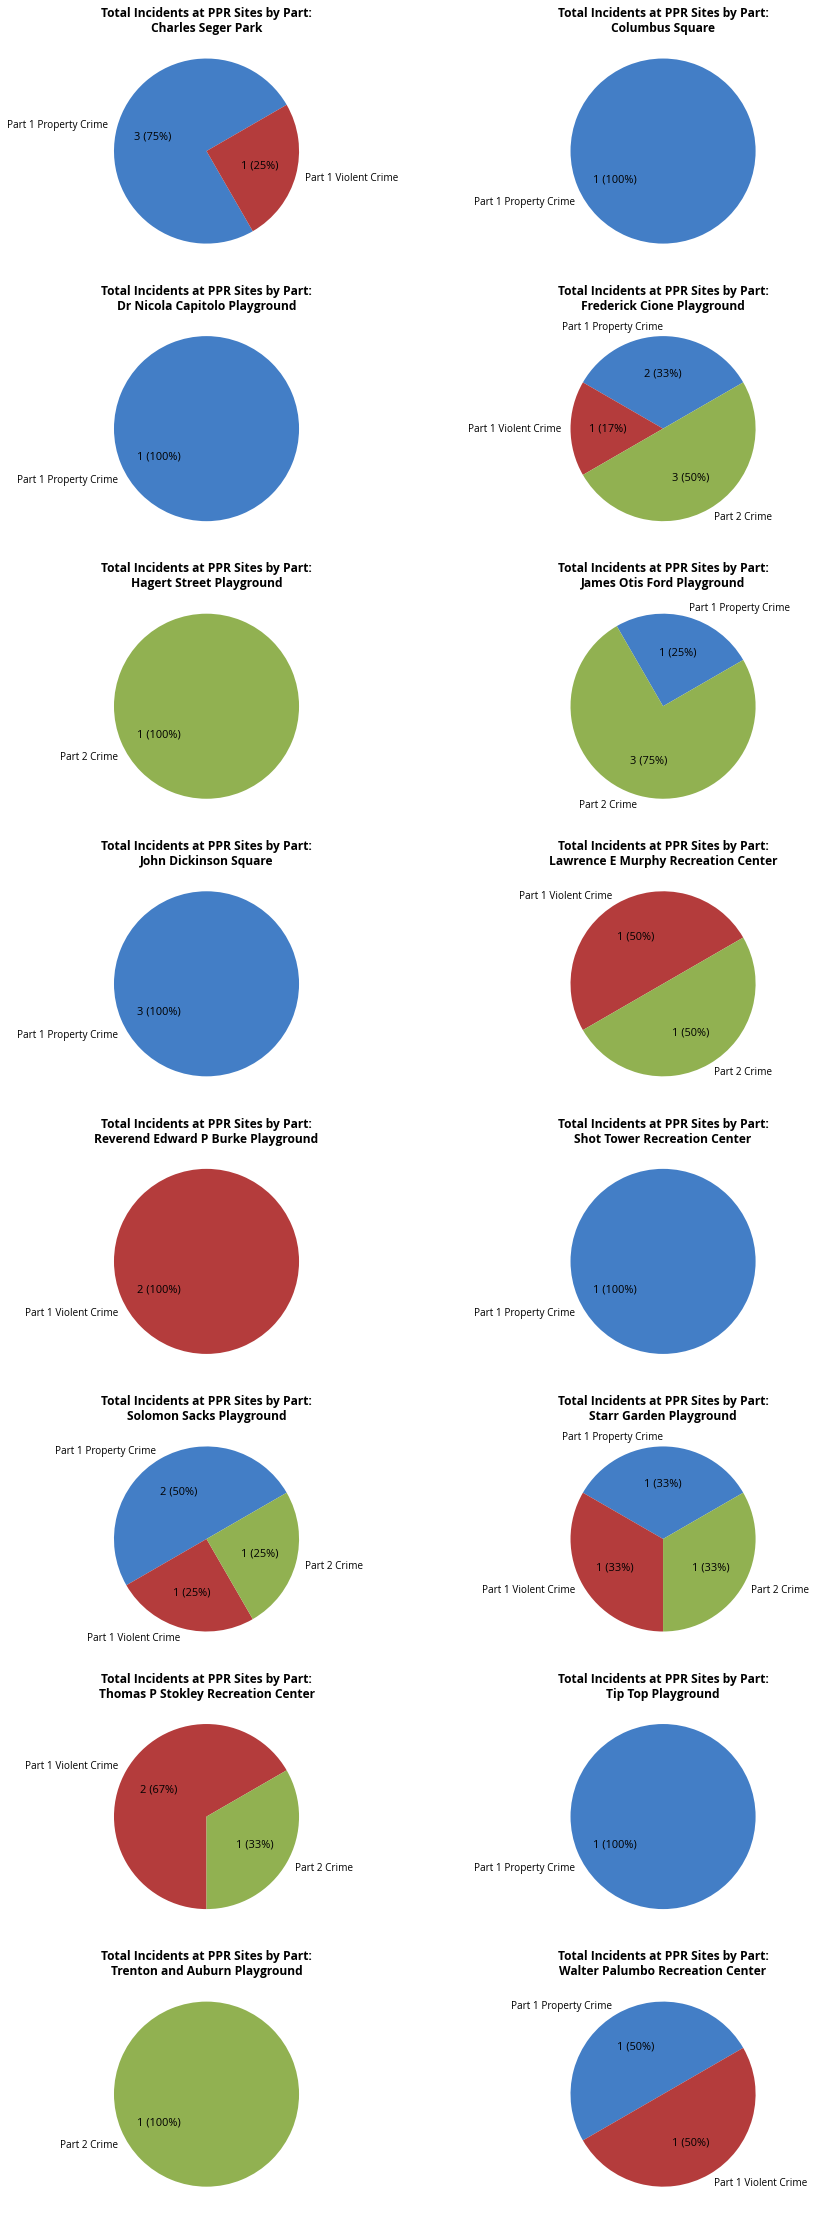

In [253]:
# import your libraries - all libraries used to generate plots need to be imported again in the cell block that generates the plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

# setting the default font settings
matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

# sets the number of pie charts and the size between the pie chart subplots
fig, axes = plt.subplots(8, 2, figsize=(15, 40)) # CHANGE! numbers for subplots and figsize parameters

# generate the pie charts - iterating over many rows in the dataframe
for i, (idx, row) in enumerate(dis1_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x),
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    # sets font size for labels
    plt.setp(autotexts, size = 11)
    
    # sets title and its font size
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis1_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

# saves all pie charts to one PNG - work on saving each pie chart as a separate PNG for future
fig.savefig(str(path) + "/Districts/District1/Site_PieCharts/dis1_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

Each site in the crime report has 4 tables: 1) the first to show incident count by crime category (top left), 2) the second to show incident count by crime type (bottom left), 3) the third to show incident count by active/non-active hours for summer only (top right), and 4) the fourth to show incident count by active/non-active hours for off-season only (bottom right). 

The below cell blocks create and export all 4 tables per site in District 1. The ouput is 4 individual styled HTML tables per site. The files will be named after the number of the table and the site name.

In [39]:
sdf.head(2)

,FID,Join_Count,TARGET_FID,JOIN_FID,DC_DIST,PSA,DISPATCH_D,DISPATCH_1,DISPATCH_T,HOUR_,DC_KEY,LOCATION_B,UCR_GENERA,TEXT_GENER,POINT_X,POINT_Y,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOU,PUBLIC_NAM,PARENT_NAM,NESTED,OFFICIAL_N,OFFICIAL_1,LABEL,ALIAS,DPP_ASSET_,ADDRESS_91,ZIP_CODE,ADDRESS_BR,ALIAS_ADDR,ACREAGE,PROPERTY_C,PPR_USE,MAINTENANC,LAND_OWNER,TENANT,ACQUISITIO,FORMER_DEP,PPR_DISTRI,PPR_OPS_DI,COUNCIL_DI,POLICE_DIS,PROGRAM_SI,PUBLIC_MAP,PUBLIC_BIG,INTERNAL_B,TPL_LAND_C,CRIME_ANAL,COMMENTS,GIS_CHRONO,DATE_EDITE,EDITED_BY,NOTES,BUFF_DIST,ORIG_FID,COUNCILDIS,COUNCILD_1,SHAPE,incident_count
0,0,1,2,7,25,1,2021-01-21,2021-01-21,02:29:53,2,202125004181,1000 BLOCK W HUNTING PARK AVE,300,Robbery Firearm,-75,40,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,Hunting Park,Hunting Park,N,,,Hunting,,845,1101 W HUNTING PARK AVE,19140,"4101 OLD YORK RD, 903 W WINGOHOCKING ST","900 HUNTING PARK AVE, 9th & Roosevelt;4101 OLD...",71,REGIONAL_PARK,RECREATION_SITE,PPR,CITY,,1854,FPC,3,3,5,25,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-01-24,PARK_C,Feature Redesign Part 1,5,12,5,5,"{""x"": 2698860.0264106393, ""y"": 259536.79384239...",26
1,1,1,5,163,16,2,2021-01-08,2021-01-08,22:15:00,22,202116000905,500 BLOCK N PAXON ST,2600,All Other Offenses,-75,40,Part 2 Crime,All Other Offenses,Off-Season,Active,West Mill Creek,West Mill Creek,N,West Mill Creek,Communications (2019),West Mill Creek,,1970,5100 WESTMINSTER AVE,19139,"525-53 N 52ND ST,5127-41&5100 WESTMINSTER AVE,...","51st & Reno;525-53 N 52ND ST,5127-41&5100 WEST...",5,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,PRA,PPR,,REC,8,8,3,16,Y,Y,Y,Y,PUBLIC_DESIGNED,Y,,2017,2022-02-16,PARK_C,Feature Redesign Part 1,5,176,3,3,"{""x"": 2676457.876661226, ""y"": 241443.434359893...",37


We will first create another dataframe that has all the information we need for the tables in particular.

In [41]:
# filter to only include crimes that occurred in District 1
dis1_tables = sdf[sdf['COUNCILD_1'] == 1]
# summarize incident count 
dis1_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis1_tables = dis1_tables.groupby(['COUNCILD_1', 'PUBLIC_NAM', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOU']).agg({'incident_count_new': 'count'}).reset_index()
dis1_tables.head(10)

__main__:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCILD_1,PUBLIC_NAM,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOU,incident_count_new
0,1,Charles Seger Park,Part 1 Property Crime,Theft,Off-Season,Active,2
1,1,Charles Seger Park,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
2,1,Charles Seger Park,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
3,1,Columbus Square,Part 1 Property Crime,Motor Vehicle Theft,Summer,Active,1
4,1,Dr Nicola Capitolo Playground,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
5,1,Frederick Cione Playground,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
6,1,Frederick Cione Playground,Part 1 Property Crime,Theft,Off-Season,Active,1
7,1,Frederick Cione Playground,Part 1 Violent Crime,Robbery,Off-Season,Active,1
8,1,Frederick Cione Playground,Part 2 Crime,All Other Offenses,Off-Season,Non-Active,2
9,1,Frederick Cione Playground,Part 2 Crime,Simple Assault,Off-Season,Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [42]:
# create the pivot table
dis1table1 = dis1_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAM', 'GIS_CRIME'], aggfunc=np.sum)
dis1table1.reset_index(inplace=True)
dis1table1.head(10)

,PUBLIC_NAM,GIS_CRIME,incident_count_new
0,Charles Seger Park,Aggravated Assault,1
1,Charles Seger Park,Theft,3
2,Columbus Square,Motor Vehicle Theft,1
3,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1
4,Frederick Cione Playground,All Other Offenses,2
5,Frederick Cione Playground,Motor Vehicle Theft,1
6,Frederick Cione Playground,Robbery,1
7,Frederick Cione Playground,Simple Assault,1
8,Frederick Cione Playground,Theft,1
9,Hagert Street Playground,Arson,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [43]:
# create a new dataframe to calculate the total number of incidents per site
dis1table1_sum= dis1table1.groupby(['PUBLIC_NAM'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis1table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis1table1.sort_values(by=['PUBLIC_NAM'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis1table1col = dis1table1[['PUBLIC_NAM', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis1table1final = pd.concat([dis1table1col, dis1table1_sum])
# our totals columns 
dis1table1final = dis1table1final.sort_values(by=['PUBLIC_NAM','grand_total'],ascending=[True,True],na_position='first')
# add our total rows to the crime category column, as that will be the first column we see in our exported tables
dis1table1final['GIS_CRIME'] =np.where(dis1table1final['grand_total'].isnull(),
                             dis1table1final['GIS_CRIME'],
                             dis1table1final['grand_total'])
# remove the total column - we no longer need it
dis1table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis1table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis1table1final.rename(columns = {'PUBLIC_NAM': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis1table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Charles Seger Park,Aggravated Assault,1
1,Charles Seger Park,Theft,3
0,Charles Seger Park,Total Incidents,4
2,Columbus Square,Motor Vehicle Theft,1
1,Columbus Square,Total Incidents,1
3,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1
2,Dr Nicola Capitolo Playground,Total Incidents,1
4,Frederick Cione Playground,All Other Offenses,2
5,Frederick Cione Playground,Motor Vehicle Theft,1
6,Frederick Cione Playground,Robbery,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [44]:
dict_site_1_1 = dict(iter(dis1table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_1_1: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_1_1[i].to_html(classes='mystyle')))

Check to make sure each site has its own table 1 in the District 1 site tables folder. Also check to make sure that each table has a total row at the bottom.

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [46]:
# set up the pivot table
dis1table2 = dis1_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAM', 'GIS_PART'], aggfunc=np.sum)
dis1table2.reset_index(inplace=True)
dis1table2.head(10)

,PUBLIC_NAM,GIS_PART,incident_count_new
0,Charles Seger Park,Part 1 Property Crime,3
1,Charles Seger Park,Part 1 Violent Crime,1
2,Columbus Square,Part 1 Property Crime,1
3,Dr Nicola Capitolo Playground,Part 1 Property Crime,1
4,Frederick Cione Playground,Part 1 Property Crime,2
5,Frederick Cione Playground,Part 1 Violent Crime,1
6,Frederick Cione Playground,Part 2 Crime,3
7,Hagert Street Playground,Part 2 Crime,1
8,James Otis Ford Playground,Part 1 Property Crime,1
9,James Otis Ford Playground,Part 2 Crime,3


In [47]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis1table2_sum= dis1table2.groupby(['PUBLIC_NAM'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis1table2_sum['grand_total'] ='Total Incidents'
dis1table2.sort_values(by=['PUBLIC_NAM'],ascending=[True],inplace=True)

dis1table2col = dis1table2[['PUBLIC_NAM', 'GIS_PART', 'incident_count_new']]
dis1table2final = pd.concat([dis1table2col, dis1table2_sum])
dis1table2final = dis1table2final.sort_values(by=['PUBLIC_NAM','grand_total'],ascending=[True,True],na_position='first')
dis1table2final['GIS_PART'] =np.where(dis1table2final['grand_total'].isnull(),
                             dis1table2final['GIS_PART'],
                             dis1table2final['grand_total'])

dis1table2final.drop(['grand_total'],axis=1,inplace=True)
dis1table2final.fillna(value=0, inplace=True)
dis1table2final.rename(columns = {'PUBLIC_NAM': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis1table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Charles Seger Park,Part 1 Property Crime,3
1,Charles Seger Park,Part 1 Violent Crime,1
0,Charles Seger Park,Total Incidents,4
2,Columbus Square,Part 1 Property Crime,1
1,Columbus Square,Total Incidents,1
3,Dr Nicola Capitolo Playground,Part 1 Property Crime,1
2,Dr Nicola Capitolo Playground,Total Incidents,1
4,Frederick Cione Playground,Part 1 Property Crime,2
5,Frederick Cione Playground,Part 1 Violent Crime,1
6,Frederick Cione Playground,Part 2 Crime,3


In [48]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_1_2 = dict(iter(dis1table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_1_2: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_1_2[i].to_html(classes='mystyle')))

Check the same site tables folder to make sure the tables have exported correctly.

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [49]:
dis1table3 = dis1_tables[dis1_tables['SEASON'] == 'Summer']
dis1table3 = dis1table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAM', 'GIS_CRIME'], columns=['ACTIVE_HOU'], aggfunc=np.sum)
dis1table3.reset_index(inplace=True)
dis1table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis1table3.head(10)

ACTIVE_HOU,PUBLIC_NAM,GIS_CRIME,Active,Non-Active
0,Columbus Square,Motor Vehicle Theft,1,0
1,James Otis Ford Playground,Simple Assault,1,0
2,James Otis Ford Playground,Theft,1,0
3,John Dickinson Square,Theft,1,0
4,Trenton and Auburn Playground,Simple Assault,1,0
5,Walter Palumbo Recreation Center,Robbery,0,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [50]:
# adding in our dataframe for the site totals
dis1table3_sum= dis1table3.groupby(['PUBLIC_NAM'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis1table3_sum['grand_total'] ='Total Incidents'
dis1table3.sort_values(by=['PUBLIC_NAM'],ascending=[True],inplace=True)

__main__:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [51]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis1table3col = dis1table3[['PUBLIC_NAM', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis1table3final = pd.concat([dis1table3col, dis1table3_sum])
dis1table3final = dis1table3final.sort_values(by=['PUBLIC_NAM','grand_total'],ascending=[True,True],na_position='first')
dis1table3final['GIS_CRIME'] =np.where(dis1table3final['grand_total'].isnull(),
                             dis1table3final['GIS_CRIME'],
                             dis1table3final['grand_total'])

dis1table3final.drop(['grand_total'],axis=1,inplace=True)
dis1table3final.fillna(value=0, inplace=True)
dis1table3final.rename(columns = {'PUBLIC_NAM': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis1table3final.head(50)

ACTIVE_HOU,Site Name,Crime Category - Summer,Active,Non-Active
0,Columbus Square,Motor Vehicle Theft,1,0
0,Columbus Square,Total Incidents,1,0
1,James Otis Ford Playground,Simple Assault,1,0
2,James Otis Ford Playground,Theft,1,0
1,James Otis Ford Playground,Total Incidents,2,0
3,John Dickinson Square,Theft,1,0
2,John Dickinson Square,Total Incidents,1,0
4,Trenton and Auburn Playground,Simple Assault,1,0
3,Trenton and Auburn Playground,Total Incidents,1,0
5,Walter Palumbo Recreation Center,Robbery,0,1


In [53]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_1_table3 = dict(iter(dis1table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_1_table3: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_1_table3[i].to_html(classes='mystyle')))

Remember that you likely will have fewer table 3s than the other tables (tables 1, 2, and 4) since sites often have  few crimes in the summer.

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [54]:
# set up our pivot table
dis1table4 = dis1_tables[dis1_tables['SEASON'] == 'Off-Season']
dis1table4 = dis1table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAM', 'GIS_CRIME'], columns=['ACTIVE_HOU'], aggfunc=np.sum)
dis1table4.reset_index(inplace=True)
dis1table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis1table4.head(10)

ACTIVE_HOU,PUBLIC_NAM,GIS_CRIME,Active,Non-Active
0,Charles Seger Park,Aggravated Assault,1,0
1,Charles Seger Park,Theft,2,1
2,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1,0
3,Frederick Cione Playground,All Other Offenses,0,2
4,Frederick Cione Playground,Motor Vehicle Theft,1,0
5,Frederick Cione Playground,Robbery,1,0
6,Frederick Cione Playground,Simple Assault,1,0
7,Frederick Cione Playground,Theft,1,0
8,Hagert Street Playground,Arson,1,0
9,James Otis Ford Playground,Simple Assault,1,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [55]:
# add the totals for each site
dis1table4_sum= dis1table4.groupby(['PUBLIC_NAM'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis1table4_sum['grand_total'] ='Total Incidents'
dis1table4.sort_values(by=['PUBLIC_NAM'],ascending=[True],inplace=True)

__main__:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [56]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis1table4col = dis1table4[['PUBLIC_NAM', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis1table4final = pd.concat([dis1table4col, dis1table4_sum])
dis1table4final = dis1table4final.sort_values(by=['PUBLIC_NAM','grand_total'],ascending=[True,True],na_position='first')
dis1table4final['GIS_CRIME'] =np.where(dis1table4final['grand_total'].isnull(),
                             dis1table4final['GIS_CRIME'],
                             dis1table4final['grand_total'])

dis1table4final.drop(['grand_total'],axis=1,inplace=True)
dis1table4final.fillna(value=0, inplace=True)
dis1table4final.rename(columns = {'PUBLIC_NAM': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis1table4final.head(10)

ACTIVE_HOU,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Charles Seger Park,Aggravated Assault,1,0
1,Charles Seger Park,Theft,2,1
0,Charles Seger Park,Total Incidents,3,1
2,Dr Nicola Capitolo Playground,Motor Vehicle Theft,1,0
1,Dr Nicola Capitolo Playground,Total Incidents,1,0
3,Frederick Cione Playground,All Other Offenses,0,2
4,Frederick Cione Playground,Motor Vehicle Theft,1,0
5,Frederick Cione Playground,Robbery,1,0
6,Frederick Cione Playground,Simple Assault,1,0
7,Frederick Cione Playground,Theft,1,0


In [57]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_1_table4 = dict(iter(dis1table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="C:/Users/HP/Desktop/CrimeReport_Share/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_1_table4: 
    with open(str(path) + '/Districts/District1/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_1_table4[i].to_html(classes='mystyle')))

### District 2

#### Main Summary Analysis Table

In [38]:
# filter original dataframe to see only District 1
dis2f = sdf[sdf['COUNCILDIS'] == 2] 

# summarize incident count
dis2 = dis2f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis2.pop('incident_count')
dis2.insert(1, 'incident_count', first_column) 

# rename columns
dis2.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis2 = dis2.append(dis2.sum(numeric_only=True), ignore_index=True)
dis2['Site Name'].fillna('Total Incidents in District', inplace=True)
dis2 = dis2.replace(np.nan, '', regex=True)

dis2.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,A Giuseppe DiSilvestro Playground,1,Part 1 Violent Crime,Robbery
1,A Giuseppe DiSilvestro Playground,1,Part 2 Crime,Simple Assault
2,A Giuseppe DiSilvestro Playground,1,Part 2 Crime,Vandalism
3,Commodore John Barry Playground,2,Part 1 Property Crime,Theft
4,Francis J Myers Recreation Center,1,Part 1 Property Crime,Motor Vehicle Theft
5,Francis J Myers Recreation Center,1,Part 1 Property Crime,Theft
6,Francis J Myers Recreation Center,1,Part 2 Crime,All Other Offenses
7,Francis J Myers Recreation Center,1,Part 2 Crime,Narcotics/Drug Law Violations
8,Francis J Myers Recreation Center,2,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act)
9,Francis J Myers Recreation Center,1,Part 2 Crime,Vandalism


In [39]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District2/Dis_OverviewPage/dis2summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis2.to_html(classes='mystyle')))

#### Main Pivot Table

In [40]:
# shape pivot table and add total column and row
dis2_pivot = dis2f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis2_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis2_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,2,,2
1,All Other Offenses,,,2,2
2,Burglary,1,,,1
3,Motor Vehicle Theft,2,,,2
4,Narcotics/Drug Law Violations,,,2,2
5,Other Sex Offenses,,,1,1
6,Robbery,,1,,1
7,Simple Assault,,,6,6
8,Theft,8,,,8
9,VUFA (Violation of the Uniform Firearm Act),,,3,3


In [41]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District2/Dis_OverviewPage/dis2pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis2_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [42]:
# for the pie chart
dis2pie = dis2f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [43]:
dis2_sites = sdf[sdf['COUNCILDIS'] == '2']
# summarize incident count
dis2_sites['incident_count_new'] = dis2_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis2_sites = dis2_sites.groupby(['COUNCILDIS', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis2_sites = dis2_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis2_sites.reset_index(inplace=True)
print(dis2_sites.shape[0]) # checks how many rows there are - SEE BELOW FOR THE OUTPUT AFTER RUNNING.

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

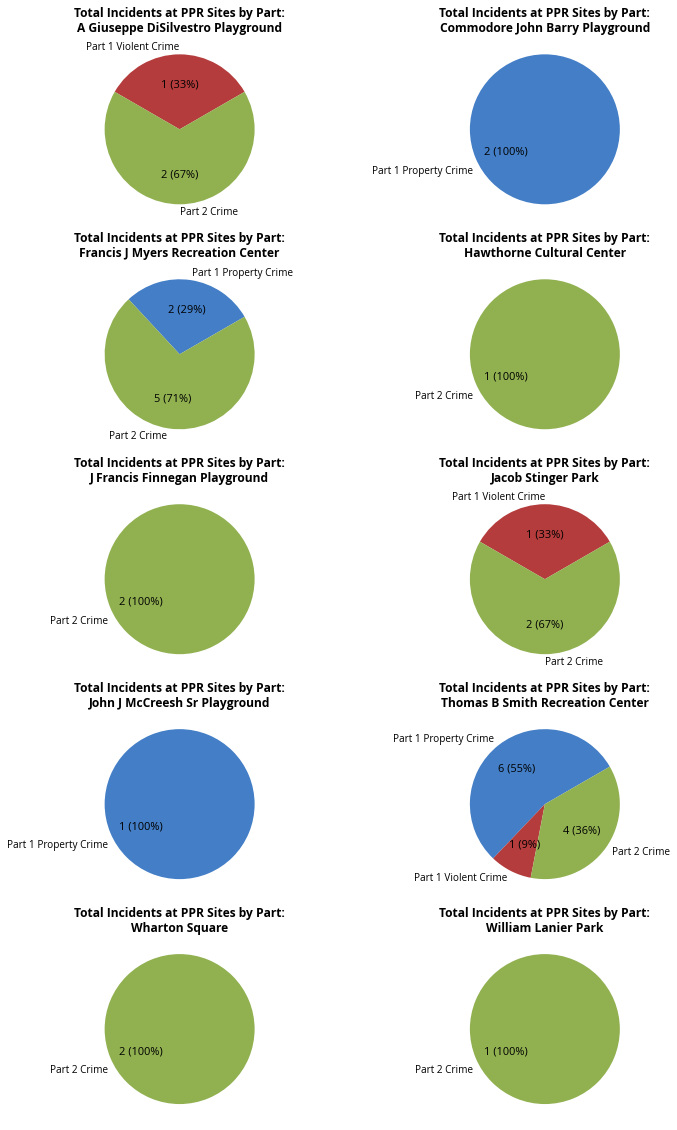

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(5, 2, figsize=(12, 20)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis2_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis2_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District2/Site_PieCharts/dis2_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [45]:
dis2_tables = sdf[sdf['COUNCIL_DISTRICT'] == '2']
# summarize incident count
dis2_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis2_tables = dis2_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis2_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,2,A Giuseppe DiSilvestro Playground,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,1
1,2,A Giuseppe DiSilvestro Playground,Part 2 Crime,Simple Assault,Off-Season,Non-Active,1
2,2,A Giuseppe DiSilvestro Playground,Part 2 Crime,Vandalism,Off-Season,Non-Active,1
3,2,Commodore John Barry Playground,Part 1 Property Crime,Theft,Off-Season,Active,2
4,2,Francis J Myers Recreation Center,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Non-Active,1
5,2,Francis J Myers Recreation Center,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
6,2,Francis J Myers Recreation Center,Part 2 Crime,All Other Offenses,Off-Season,Non-Active,1
7,2,Francis J Myers Recreation Center,Part 2 Crime,Narcotics/Drug Law Violations,Off-Season,Active,1
8,2,Francis J Myers Recreation Center,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act),Off-Season,Active,2
9,2,Francis J Myers Recreation Center,Part 2 Crime,Vandalism,Off-Season,Non-Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [46]:
# create the pivot table
dis2table1 = dis2_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis2table1.reset_index(inplace=True)
dis2table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,A Giuseppe DiSilvestro Playground,Robbery,1
1,A Giuseppe DiSilvestro Playground,Simple Assault,1
2,A Giuseppe DiSilvestro Playground,Vandalism,1
3,Commodore John Barry Playground,Theft,2
4,Francis J Myers Recreation Center,All Other Offenses,1
5,Francis J Myers Recreation Center,Motor Vehicle Theft,1
6,Francis J Myers Recreation Center,Narcotics/Drug Law Violations,1
7,Francis J Myers Recreation Center,Theft,1
8,Francis J Myers Recreation Center,VUFA (Violation of the Uniform Firearm Act),2
9,Francis J Myers Recreation Center,Vandalism,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [47]:
# create a new dataframe to calculate the total number of incidents per site
dis2table1_sum= dis2table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis2table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis2table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis2table1col = dis2table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis2table1final = pd.concat([dis2table1col, dis2table1_sum])
# our totals columns 
dis2table1final = dis2table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis2table1final['GIS_CRIME'] =np.where(dis2table1final['grand_total'].isnull(),
                             dis2table1final['GIS_CRIME'],
                             dis2table1final['grand_total'])
# remove the total column - we no longer need it
dis2table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis2table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis2table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis2table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,A Giuseppe DiSilvestro Playground,Robbery,1
1,A Giuseppe DiSilvestro Playground,Simple Assault,1
2,A Giuseppe DiSilvestro Playground,Vandalism,1
0,A Giuseppe DiSilvestro Playground,Total Incidents,3
3,Commodore John Barry Playground,Theft,2
1,Commodore John Barry Playground,Total Incidents,2
4,Francis J Myers Recreation Center,All Other Offenses,1
5,Francis J Myers Recreation Center,Motor Vehicle Theft,1
6,Francis J Myers Recreation Center,Narcotics/Drug Law Violations,1
7,Francis J Myers Recreation Center,Theft,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [48]:
dict_site_2_1 = dict(iter(dis2table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_2_1: 
    with open(str(path) + '/Districts/District2/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_2_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [49]:
# set up the pivot table
dis2table2 = dis2_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis2table2.reset_index(inplace=True)
dis2table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,A Giuseppe DiSilvestro Playground,Part 1 Violent Crime,1
1,A Giuseppe DiSilvestro Playground,Part 2 Crime,2
2,Commodore John Barry Playground,Part 1 Property Crime,2
3,Francis J Myers Recreation Center,Part 1 Property Crime,2
4,Francis J Myers Recreation Center,Part 2 Crime,5
5,Hawthorne Cultural Center,Part 2 Crime,1
6,J Francis Finnegan Playground,Part 2 Crime,2
7,Jacob Stinger Park,Part 1 Violent Crime,1
8,Jacob Stinger Park,Part 2 Crime,2
9,John J McCreesh Sr Playground,Part 1 Property Crime,1


In [50]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis2table2_sum= dis2table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis2table2_sum['grand_total'] ='Total Incidents'
dis2table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis2table2col = dis2table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis2table2final = pd.concat([dis2table2col, dis2table2_sum])
dis2table2final = dis2table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis2table2final['GIS_PART'] =np.where(dis2table2final['grand_total'].isnull(),
                             dis2table2final['GIS_PART'],
                             dis2table2final['grand_total'])

dis2table2final.drop(['grand_total'],axis=1,inplace=True)
dis2table2final.fillna(value=0, inplace=True)
dis2table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis2table2final.head(10)

,Site Name,Crime Type,Incident Count
0,A Giuseppe DiSilvestro Playground,Part 1 Violent Crime,1
1,A Giuseppe DiSilvestro Playground,Part 2 Crime,2
0,A Giuseppe DiSilvestro Playground,Total Incidents,3
2,Commodore John Barry Playground,Part 1 Property Crime,2
1,Commodore John Barry Playground,Total Incidents,2
3,Francis J Myers Recreation Center,Part 1 Property Crime,2
4,Francis J Myers Recreation Center,Part 2 Crime,5
2,Francis J Myers Recreation Center,Total Incidents,7
5,Hawthorne Cultural Center,Part 2 Crime,1
3,Hawthorne Cultural Center,Total Incidents,1


In [51]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_2_2 = dict(iter(dis2table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_2_2: 
    with open(str(path) + '/Districts/District2/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_2_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [52]:
dis2table3 = dis2_tables[dis2_tables['SEASON'] == 'Summer']
dis2table3 = dis2table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis2table3.reset_index(inplace=True)
dis2table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis2table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active
0,Thomas B Smith Recreation Center,Simple Assault,1
1,William Lanier Park,Narcotics/Drug Law Violations,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [54]:
# adding in our dataframe for the site totals
dis2table3_sum= dis2table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis2table3_sum['grand_total'] ='Total Incidents'
dis2table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [56]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis2table3col = dis2table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis2table3final = pd.concat([dis2table3col, dis2table3_sum])
dis2table3final = dis2table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis2table3final['GIS_CRIME'] =np.where(dis2table3final['grand_total'].isnull(),
                             dis2table3final['GIS_CRIME'],
                             dis2table3final['grand_total'])

dis2table3final.drop(['grand_total'],axis=1,inplace=True)
dis2table3final.fillna(value=0, inplace=True)
dis2table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis2table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active
0,Thomas B Smith Recreation Center,Simple Assault,1
0,Thomas B Smith Recreation Center,Total Incidents,1
1,William Lanier Park,Narcotics/Drug Law Violations,1
1,William Lanier Park,Total Incidents,1


In [57]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_2_table3 = dict(iter(dis2table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_2_table3: 
    with open(str(path) + '/Districts/District2/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_2_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [58]:
# set up our pivot table
dis2table4 = dis2_tables[dis2_tables['SEASON'] == 'Off-Season']
dis2table4 = dis2table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis2table4.reset_index(inplace=True)
dis2table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis2table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,A Giuseppe DiSilvestro Playground,Robbery,0,1
1,A Giuseppe DiSilvestro Playground,Simple Assault,0,1
2,A Giuseppe DiSilvestro Playground,Vandalism,0,1
3,Commodore John Barry Playground,Theft,2,0
4,Francis J Myers Recreation Center,All Other Offenses,0,1
5,Francis J Myers Recreation Center,Motor Vehicle Theft,0,1
6,Francis J Myers Recreation Center,Narcotics/Drug Law Violations,1,0
7,Francis J Myers Recreation Center,Theft,0,1
8,Francis J Myers Recreation Center,VUFA (Violation of the Uniform Firearm Act),2,0
9,Francis J Myers Recreation Center,Vandalism,0,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [59]:
# add the totals for each site
dis2table4_sum= dis2table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis2table4_sum['grand_total'] ='Total Incidents'
dis2table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [60]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis2table4col = dis2table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis2table4final = pd.concat([dis2table4col, dis2table4_sum])
dis2table4final = dis2table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis2table4final['GIS_CRIME'] =np.where(dis2table4final['grand_total'].isnull(),
                             dis2table4final['GIS_CRIME'],
                             dis2table4final['grand_total'])

dis2table4final.drop(['grand_total'],axis=1,inplace=True)
dis2table4final.fillna(value=0, inplace=True)
dis2table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis2table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,A Giuseppe DiSilvestro Playground,Robbery,0,1
1,A Giuseppe DiSilvestro Playground,Simple Assault,0,1
2,A Giuseppe DiSilvestro Playground,Vandalism,0,1
0,A Giuseppe DiSilvestro Playground,Total Incidents,0,3
3,Commodore John Barry Playground,Theft,2,0
1,Commodore John Barry Playground,Total Incidents,2,0
4,Francis J Myers Recreation Center,All Other Offenses,0,1
5,Francis J Myers Recreation Center,Motor Vehicle Theft,0,1
6,Francis J Myers Recreation Center,Narcotics/Drug Law Violations,1,0
7,Francis J Myers Recreation Center,Theft,0,1


In [61]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_2_table4 = dict(iter(dis2table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_2_table4: 
    with open(str(path) + '/Districts/District2/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_2_table4[i].to_html(classes='mystyle')))

### District 3

#### Main Summary Analysis Table

In [62]:
# filter original dataframe to see only District 1
dis3f = sdf[sdf['COUNCILDIS'] == 3] 

# summarize incident count
dis3 = dis3f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis3.pop('incident_count')
dis3.insert(1, 'incident_count', first_column) 

# rename columns
dis3.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis3 = dis3.append(dis3.sum(numeric_only=True), ignore_index=True)
dis3['Site Name'].fillna('Total Incidents in District', inplace=True)
dis3 = dis3.replace(np.nan, '', regex=True)

dis3.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Albert W Christy Sr Recreation Center,1,Part 1 Property Crime,Theft
1,Clayborne and Lewis Playground,1,Part 2 Crime,Vandalism
2,Conestoga Community Playground,2,Part 1 Violent Crime,Robbery
3,West Mill Creek,1,Part 1 Property Crime,Motor Vehicle Theft
4,West Mill Creek,1,Part 1 Property Crime,Theft
5,West Mill Creek,2,Part 1 Violent Crime,Aggravated Assault
6,West Mill Creek,25,Part 2 Crime,All Other Offenses
7,West Mill Creek,5,Part 2 Crime,Narcotics/Drug Law Violations
8,West Mill Creek,2,Part 2 Crime,Prostitution and Commercialized Vice
9,West Mill Creek,1,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act)


In [63]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District3/Dis_OverviewPage/dis3summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis3.to_html(classes='mystyle')))

#### Main Pivot Table

In [64]:
# shape pivot table and add total column and row
dis3_pivot = dis3f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis3_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis3_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,2,,2
1,All Other Offenses,,,25,25
2,Motor Vehicle Theft,1,,,1
3,Narcotics/Drug Law Violations,,,5,5
4,Prostitution and Commercialized Vice,,,2,2
5,Robbery,,2,,2
6,Theft,2,,,2
7,VUFA (Violation of the Uniform Firearm Act),,,1,1
8,Vandalism,,,1,1
9,Total,3,4,34,41


In [65]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District3/Dis_OverviewPage/dis3pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis3_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [66]:
# for the pie chart
dis3pie = dis3f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [67]:
dis3_sites = sdf[sdf['COUNCIL_DISTRICT'] == '3']
# summarize incident count
dis3_sites['incident_count_new'] = dis3_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis3_sites = dis3_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis3_sites = dis3_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis3_sites.reset_index(inplace=True)
print(dis3_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

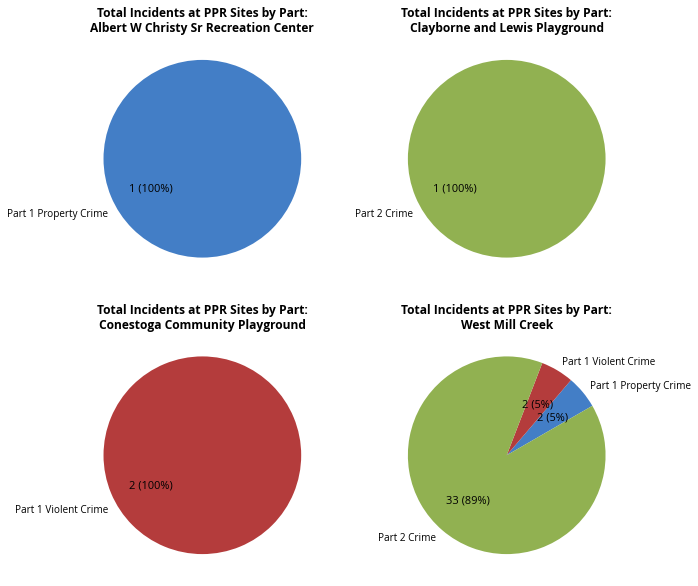

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(2, 2, figsize=(10, 10)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis3_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis3_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District3/Site_PieCharts/dis3_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [69]:
dis3_tables = sdf[sdf['COUNCIL_DISTRICT'] == '3']
# summarize incident count
dis3_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis3_tables = dis3_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis3_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,3,Albert W Christy Sr Recreation Center,Part 1 Property Crime,Theft,Summer,Non-Active,1
1,3,Clayborne and Lewis Playground,Part 2 Crime,Vandalism,Off-Season,Active,1
2,3,Conestoga Community Playground,Part 1 Violent Crime,Robbery,Off-Season,Active,1
3,3,Conestoga Community Playground,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,1
4,3,West Mill Creek,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
5,3,West Mill Creek,Part 1 Property Crime,Theft,Off-Season,Active,1
6,3,West Mill Creek,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
7,3,West Mill Creek,Part 1 Violent Crime,Aggravated Assault,Off-Season,Non-Active,1
8,3,West Mill Creek,Part 2 Crime,All Other Offenses,Off-Season,Active,25
9,3,West Mill Creek,Part 2 Crime,Narcotics/Drug Law Violations,Off-Season,Active,4


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [70]:
# create the pivot table
dis3table1 = dis3_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis3table1.reset_index(inplace=True)
dis3table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,Albert W Christy Sr Recreation Center,Theft,1
1,Clayborne and Lewis Playground,Vandalism,1
2,Conestoga Community Playground,Robbery,2
3,West Mill Creek,Aggravated Assault,2
4,West Mill Creek,All Other Offenses,25
5,West Mill Creek,Motor Vehicle Theft,1
6,West Mill Creek,Narcotics/Drug Law Violations,5
7,West Mill Creek,Prostitution and Commercialized Vice,2
8,West Mill Creek,Theft,1
9,West Mill Creek,VUFA (Violation of the Uniform Firearm Act),1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [71]:
# create a new dataframe to calculate the total number of incidents per site
dis3table1_sum= dis3table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis3table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis3table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis3table1col = dis3table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis3table1final = pd.concat([dis3table1col, dis3table1_sum])
# our totals columns 
dis3table1final = dis3table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis3table1final['GIS_CRIME'] =np.where(dis3table1final['grand_total'].isnull(),
                             dis3table1final['GIS_CRIME'],
                             dis3table1final['grand_total'])
# remove the total column - we no longer need it
dis3table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis3table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis3table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis3table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Albert W Christy Sr Recreation Center,Theft,1
0,Albert W Christy Sr Recreation Center,Total Incidents,1
1,Clayborne and Lewis Playground,Vandalism,1
1,Clayborne and Lewis Playground,Total Incidents,1
2,Conestoga Community Playground,Robbery,2
2,Conestoga Community Playground,Total Incidents,2
3,West Mill Creek,Aggravated Assault,2
4,West Mill Creek,All Other Offenses,25
5,West Mill Creek,Motor Vehicle Theft,1
6,West Mill Creek,Narcotics/Drug Law Violations,5


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [72]:
dict_site_3_1 = dict(iter(dis3table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_3_1: 
    with open(str(path) + '/Districts/District3/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_3_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [73]:
# set up the pivot table
dis3table2 = dis3_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis3table2.reset_index(inplace=True)
dis3table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,Albert W Christy Sr Recreation Center,Part 1 Property Crime,1
1,Clayborne and Lewis Playground,Part 2 Crime,1
2,Conestoga Community Playground,Part 1 Violent Crime,2
3,West Mill Creek,Part 1 Property Crime,2
4,West Mill Creek,Part 1 Violent Crime,2
5,West Mill Creek,Part 2 Crime,33


In [74]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis3table2_sum= dis3table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis3table2_sum['grand_total'] ='Total Incidents'
dis3table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis3table2col = dis3table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis3table2final = pd.concat([dis3table2col, dis3table2_sum])
dis3table2final = dis3table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis3table2final['GIS_PART'] =np.where(dis3table2final['grand_total'].isnull(),
                             dis3table2final['GIS_PART'],
                             dis3table2final['grand_total'])

dis3table2final.drop(['grand_total'],axis=1,inplace=True)
dis3table2final.fillna(value=0, inplace=True)
dis3table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis3table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Albert W Christy Sr Recreation Center,Part 1 Property Crime,1
0,Albert W Christy Sr Recreation Center,Total Incidents,1
1,Clayborne and Lewis Playground,Part 2 Crime,1
1,Clayborne and Lewis Playground,Total Incidents,1
2,Conestoga Community Playground,Part 1 Violent Crime,2
2,Conestoga Community Playground,Total Incidents,2
3,West Mill Creek,Part 1 Property Crime,2
4,West Mill Creek,Part 1 Violent Crime,2
5,West Mill Creek,Part 2 Crime,33
3,West Mill Creek,Total Incidents,37


In [75]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_3_2 = dict(iter(dis3table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_3_2: 
    with open(str(path) + '/Districts/District3/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_3_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [76]:
dis3table3 = dis3_tables[dis3_tables['SEASON'] == 'Summer']
dis3table3 = dis3table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis3table3.reset_index(inplace=True)
dis3table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis3table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Non-Active
0,Albert W Christy Sr Recreation Center,Theft,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [77]:
# adding in our dataframe for the site totals
dis3table3_sum= dis3table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis3table3_sum['grand_total'] ='Total Incidents'
dis3table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [78]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis3table3col = dis3table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis3table3final = pd.concat([dis3table3col, dis3table3_sum])
dis3table3final = dis3table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis3table3final['GIS_CRIME'] =np.where(dis3table3final['grand_total'].isnull(),
                             dis3table3final['GIS_CRIME'],
                             dis3table3final['grand_total'])

dis3table3final.drop(['grand_total'],axis=1,inplace=True)
dis3table3final.fillna(value=0, inplace=True)
dis3table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis3table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Non-Active
0,Albert W Christy Sr Recreation Center,Theft,1
0,Albert W Christy Sr Recreation Center,Total Incidents,1


In [79]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_3_table3 = dict(iter(dis3table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_3_table3: 
    with open(str(path) + '/Districts/District3/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_3_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [80]:
# set up our pivot table
dis3table4 = dis3_tables[dis3_tables['SEASON'] == 'Off-Season']
dis3table4 = dis3table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis3table4.reset_index(inplace=True)
dis3table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis3table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Clayborne and Lewis Playground,Vandalism,1,0
1,Conestoga Community Playground,Robbery,1,1
2,West Mill Creek,Aggravated Assault,1,1
3,West Mill Creek,All Other Offenses,25,0
4,West Mill Creek,Motor Vehicle Theft,1,0
5,West Mill Creek,Narcotics/Drug Law Violations,4,1
6,West Mill Creek,Prostitution and Commercialized Vice,1,1
7,West Mill Creek,Theft,1,0
8,West Mill Creek,VUFA (Violation of the Uniform Firearm Act),0,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [81]:
# add the totals for each site
dis3table4_sum= dis3table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis3table4_sum['grand_total'] ='Total Incidents'
dis3table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [82]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis3table4col = dis3table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis3table4final = pd.concat([dis3table4col, dis3table4_sum])
dis3table4final = dis3table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis3table4final['GIS_CRIME'] =np.where(dis3table4final['grand_total'].isnull(),
                             dis3table4final['GIS_CRIME'],
                             dis3table4final['grand_total'])

dis3table4final.drop(['grand_total'],axis=1,inplace=True)
dis3table4final.fillna(value=0, inplace=True)
dis3table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis3table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Clayborne and Lewis Playground,Vandalism,1,0
0,Clayborne and Lewis Playground,Total Incidents,1,0
1,Conestoga Community Playground,Robbery,1,1
1,Conestoga Community Playground,Total Incidents,1,1
2,West Mill Creek,Aggravated Assault,1,1
3,West Mill Creek,All Other Offenses,25,0
4,West Mill Creek,Motor Vehicle Theft,1,0
5,West Mill Creek,Narcotics/Drug Law Violations,4,1
6,West Mill Creek,Prostitution and Commercialized Vice,1,1
7,West Mill Creek,Theft,1,0


In [83]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_3_table4 = dict(iter(dis3table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_3_table4: 
    with open(str(path) + '/Districts/District3/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_3_table4[i].to_html(classes='mystyle')))

### District 4

#### Main Summary Analysis Table

In [84]:
# filter original dataframe to see only District 1
dis4f = sdf[sdf['COUNCILDIS'] == 4] 

# summarize incident count
dis4 = dis4f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis4.pop('incident_count')
dis4.insert(1, 'incident_count', first_column) 

# rename columns
dis4.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

# add a row at the bottom for total incidents
dis4 = dis4.append(dis4.sum(numeric_only=True), ignore_index=True)
dis4['Site Name'].fillna('Total Incidents in District', inplace=True)

# fill in NAs and any decimals
dis4 = dis4.replace(np.nan, '', regex=True)
pd.set_option('precision', 0) # if having issues with decimals showing instead of whole numbers

dis4.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,29th and Chalmers Playground,1,Part 1 Violent Crime,Aggravated Assault
1,Ernest L Tustin Recreation Center,1,Part 2 Crime,Simple Assault
2,Haddington-Marshall L Shepard Sr Recreation Ce...,1,Part 1 Violent Crime,Aggravated Assault
3,Haddington-Marshall L Shepard Sr Recreation Ce...,2,Part 1 Violent Crime,Robbery
4,Haddington-Marshall L Shepard Sr Recreation Ce...,6,Part 2 Crime,All Other Offenses
5,Haddington-Marshall L Shepard Sr Recreation Ce...,1,Part 2 Crime,Vandalism
6,Hillside Recreation Center,2,Part 2 Crime,Simple Assault
7,Venice Island Performing Arts and Recreation C...,1,Part 1 Property Crime,Theft
8,W Freeland Kendrick Recreation Center,6,Part 1 Property Crime,Theft
9,W Freeland Kendrick Recreation Center,2,Part 1 Violent Crime,Aggravated Assault


In [85]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
      </body>
</html>.
'''

with open(str(path) + "/Districts/District4/Dis_OverviewPage/dis4summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis4.to_html(classes='mystyle')))

#### Main Pivot Table

In [86]:
# shape pivot table and add total column and row
dis4_pivot = dis4f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis4_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis4_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,4,,4
1,All Other Offenses,,,6,6
2,Narcotics/Drug Law Violations,,,1,1
3,Rape,,1,,1
4,Robbery,,2,,2
5,Simple Assault,,,4,4
6,Theft,7,,,7
7,VUFA (Violation of the Uniform Firearm Act),,,1,1
8,Vandalism,,,3,3
9,Total,7,7,15,29


In [87]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District4/Dis_OverviewPage/dis4pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis4_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [88]:
# for the pie chart
dis4pie = dis4f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [89]:
dis4_sites = sdf[sdf['COUNCIL_DISTRICT'] == '4']
# summarize incident count
dis4_sites['incident_count_new'] = dis4_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis4_sites = dis4_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis4_sites = dis4_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis4_sites.reset_index(inplace=True)
print(dis4_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

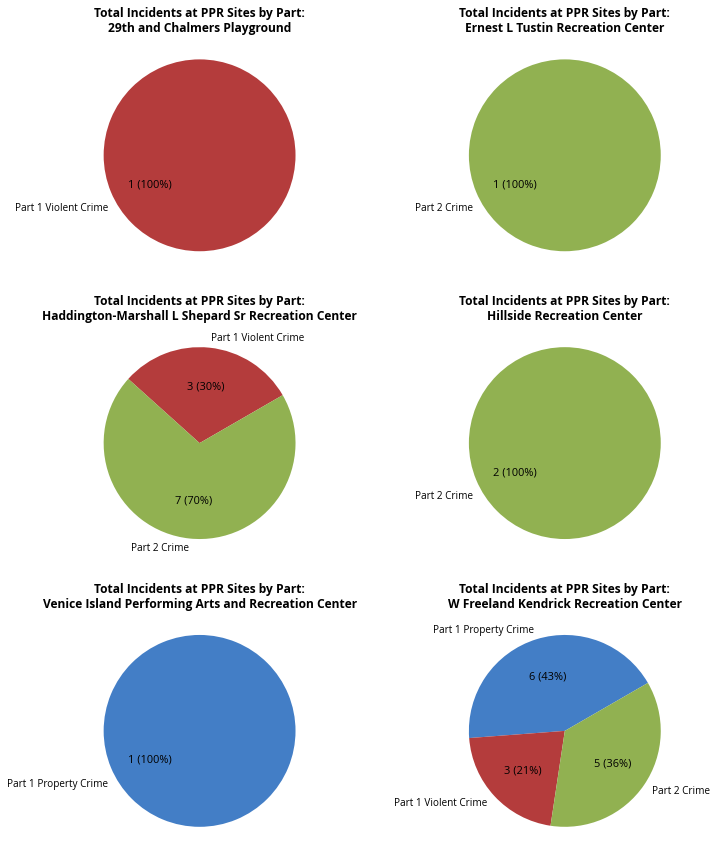

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(3, 2, figsize=(12, 15)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis4_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis4_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District4/Site_PieCharts/dis4_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [91]:
dis4_tables = sdf[sdf['COUNCIL_DISTRICT'] == '4']
# summarize incident count
dis4_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis4_tables = dis4_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis4_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,4,29th and Chalmers Playground,Part 1 Violent Crime,Aggravated Assault,Off-Season,Non-Active,1
1,4,Ernest L Tustin Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Active,1
2,4,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
3,4,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 1 Violent Crime,Robbery,Off-Season,Active,2
4,4,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 2 Crime,All Other Offenses,Summer,Active,2
5,4,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 2 Crime,All Other Offenses,Summer,Non-Active,4
6,4,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 2 Crime,Vandalism,Off-Season,Non-Active,1
7,4,Hillside Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Active,1
8,4,Hillside Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Non-Active,1
9,4,Venice Island Performing Arts and Recreation C...,Part 1 Property Crime,Theft,Off-Season,Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [92]:
# create the pivot table
dis4table1 = dis4_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis4table1.reset_index(inplace=True)
dis4table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,29th and Chalmers Playground,Aggravated Assault,1
1,Ernest L Tustin Recreation Center,Simple Assault,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Aggravated Assault,1
3,Haddington-Marshall L Shepard Sr Recreation Ce...,All Other Offenses,6
4,Haddington-Marshall L Shepard Sr Recreation Ce...,Robbery,2
5,Haddington-Marshall L Shepard Sr Recreation Ce...,Vandalism,1
6,Hillside Recreation Center,Simple Assault,2
7,Venice Island Performing Arts and Recreation C...,Theft,1
8,W Freeland Kendrick Recreation Center,Aggravated Assault,2
9,W Freeland Kendrick Recreation Center,Narcotics/Drug Law Violations,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [93]:
# create a new dataframe to calculate the total number of incidents per site
dis4table1_sum= dis4table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis4table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis4table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis4table1col = dis4table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis4table1final = pd.concat([dis4table1col, dis4table1_sum])
# our totals columns 
dis4table1final = dis4table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis4table1final['GIS_CRIME'] =np.where(dis4table1final['grand_total'].isnull(),
                             dis4table1final['GIS_CRIME'],
                             dis4table1final['grand_total'])
# remove the total column - we no longer need it
dis4table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis4table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis4table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis4table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,29th and Chalmers Playground,Aggravated Assault,1
0,29th and Chalmers Playground,Total Incidents,1
1,Ernest L Tustin Recreation Center,Simple Assault,1
1,Ernest L Tustin Recreation Center,Total Incidents,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Aggravated Assault,1
3,Haddington-Marshall L Shepard Sr Recreation Ce...,All Other Offenses,6
4,Haddington-Marshall L Shepard Sr Recreation Ce...,Robbery,2
5,Haddington-Marshall L Shepard Sr Recreation Ce...,Vandalism,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Total Incidents,10
6,Hillside Recreation Center,Simple Assault,2


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [94]:
dict_site_4_1 = dict(iter(dis4table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_4_1: 
    with open(str(path) + '/Districts/District4/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_4_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [95]:
# set up the pivot table
dis4table2 = dis4_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis4table2.reset_index(inplace=True)
dis4table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,29th and Chalmers Playground,Part 1 Violent Crime,1
1,Ernest L Tustin Recreation Center,Part 2 Crime,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 1 Violent Crime,3
3,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 2 Crime,7
4,Hillside Recreation Center,Part 2 Crime,2
5,Venice Island Performing Arts and Recreation C...,Part 1 Property Crime,1
6,W Freeland Kendrick Recreation Center,Part 1 Property Crime,6
7,W Freeland Kendrick Recreation Center,Part 1 Violent Crime,3
8,W Freeland Kendrick Recreation Center,Part 2 Crime,5


In [96]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis4table2_sum= dis4table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis4table2_sum['grand_total'] ='Total Incidents'
dis4table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis4table2col = dis4table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis4table2final = pd.concat([dis4table2col, dis4table2_sum])
dis4table2final = dis4table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis4table2final['GIS_PART'] =np.where(dis4table2final['grand_total'].isnull(),
                             dis4table2final['GIS_PART'],
                             dis4table2final['grand_total'])

dis4table2final.drop(['grand_total'],axis=1,inplace=True)
dis4table2final.fillna(value=0, inplace=True)
dis4table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis4table2final.head(10)

,Site Name,Crime Type,Incident Count
0,29th and Chalmers Playground,Part 1 Violent Crime,1
0,29th and Chalmers Playground,Total Incidents,1
1,Ernest L Tustin Recreation Center,Part 2 Crime,1
1,Ernest L Tustin Recreation Center,Total Incidents,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 1 Violent Crime,3
3,Haddington-Marshall L Shepard Sr Recreation Ce...,Part 2 Crime,7
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Total Incidents,10
4,Hillside Recreation Center,Part 2 Crime,2
3,Hillside Recreation Center,Total Incidents,2
5,Venice Island Performing Arts and Recreation C...,Part 1 Property Crime,1


In [97]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_4_2 = dict(iter(dis4table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_4_2: 
    with open(str(path) + '/Districts/District4/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_4_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [98]:
dis4table3 = dis4_tables[dis4_tables['SEASON'] == 'Summer']
dis4table3 = dis4table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis4table3.reset_index(inplace=True)
dis4table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis4table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Haddington-Marshall L Shepard Sr Recreation Ce...,All Other Offenses,2,4
1,W Freeland Kendrick Recreation Center,Aggravated Assault,0,1
2,W Freeland Kendrick Recreation Center,Rape,1,0
3,W Freeland Kendrick Recreation Center,Theft,1,0
4,W Freeland Kendrick Recreation Center,Vandalism,1,0


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [99]:
# adding in our dataframe for the site totals
dis4table3_sum= dis4table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis4table3_sum['grand_total'] ='Total Incidents'
dis4table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [100]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis4table3col = dis4table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis4table3final = pd.concat([dis4table3col, dis4table3_sum])
dis4table3final = dis4table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis4table3final['GIS_CRIME'] =np.where(dis4table3final['grand_total'].isnull(),
                             dis4table3final['GIS_CRIME'],
                             dis4table3final['grand_total'])

dis4table3final.drop(['grand_total'],axis=1,inplace=True)
dis4table3final.fillna(value=0, inplace=True)
dis4table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis4table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active,Non-Active
0,Haddington-Marshall L Shepard Sr Recreation Ce...,All Other Offenses,2,4
0,Haddington-Marshall L Shepard Sr Recreation Ce...,Total Incidents,2,4
1,W Freeland Kendrick Recreation Center,Aggravated Assault,0,1
2,W Freeland Kendrick Recreation Center,Rape,1,0
3,W Freeland Kendrick Recreation Center,Theft,1,0
4,W Freeland Kendrick Recreation Center,Vandalism,1,0
1,W Freeland Kendrick Recreation Center,Total Incidents,3,1


In [101]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_4_table3 = dict(iter(dis4table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_4_table3: 
    with open(str(path) + '/Districts/District4/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_4_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [102]:
# set up our pivot table
dis4table4 = dis4_tables[dis4_tables['SEASON'] == 'Off-Season']
dis4table4 = dis4table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis4table4.reset_index(inplace=True)
dis4table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis4table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,29th and Chalmers Playground,Aggravated Assault,0,1
1,Ernest L Tustin Recreation Center,Simple Assault,1,0
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Aggravated Assault,1,0
3,Haddington-Marshall L Shepard Sr Recreation Ce...,Robbery,2,0
4,Haddington-Marshall L Shepard Sr Recreation Ce...,Vandalism,0,1
5,Hillside Recreation Center,Simple Assault,1,1
6,Venice Island Performing Arts and Recreation C...,Theft,1,0
7,W Freeland Kendrick Recreation Center,Aggravated Assault,0,1
8,W Freeland Kendrick Recreation Center,Narcotics/Drug Law Violations,0,1
9,W Freeland Kendrick Recreation Center,Simple Assault,0,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [103]:
# add the totals for each site
dis4table4_sum= dis4table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis4table4_sum['grand_total'] ='Total Incidents'
dis4table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [104]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis4table4col = dis4table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis4table4final = pd.concat([dis4table4col, dis4table4_sum])
dis4table4final = dis4table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis4table4final['GIS_CRIME'] =np.where(dis4table4final['grand_total'].isnull(),
                             dis4table4final['GIS_CRIME'],
                             dis4table4final['grand_total'])

dis4table4final.drop(['grand_total'],axis=1,inplace=True)
dis4table4final.fillna(value=0, inplace=True)
dis4table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis4table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,29th and Chalmers Playground,Aggravated Assault,0,1
0,29th and Chalmers Playground,Total Incidents,0,1
1,Ernest L Tustin Recreation Center,Simple Assault,1,0
1,Ernest L Tustin Recreation Center,Total Incidents,1,0
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Aggravated Assault,1,0
3,Haddington-Marshall L Shepard Sr Recreation Ce...,Robbery,2,0
4,Haddington-Marshall L Shepard Sr Recreation Ce...,Vandalism,0,1
2,Haddington-Marshall L Shepard Sr Recreation Ce...,Total Incidents,3,1
5,Hillside Recreation Center,Simple Assault,1,1
3,Hillside Recreation Center,Total Incidents,1,1


In [105]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_4_table4 = dict(iter(dis4table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_4_table4: 
    with open(str(path) + '/Districts/District4/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_4_table4[i].to_html(classes='mystyle')))

### District 5

#### Main Summary Analysis Table

In [106]:
# filter original dataframe to see only District 1
dis5f = sdf[sdf['COUNCILDIS'] == 5] 

# summarize incident count
dis5 = dis5f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis5.pop('incident_count')
dis5.insert(1, 'incident_count', first_column) 

# rename columns
dis5.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis5 = dis5.append(dis5.sum(numeric_only=True), ignore_index=True)
dis5['Site Name'].fillna('Total Incidents in District', inplace=True)
dis5 = dis5.replace(np.nan, '', regex=True)

dis5.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,12th and Cambria Playground,1,Part 1 Property Crime,Motor Vehicle Theft
1,12th and Cambria Playground,1,Part 2 Crime,Vandalism
2,East Poplar Playground,1,Part 1 Property Crime,Motor Vehicle Theft
3,East Poplar Playground,6,Part 1 Property Crime,Theft
4,East Poplar Playground,1,Part 2 Crime,All Other Offenses
5,East Poplar Playground,1,Part 2 Crime,Narcotics/Drug Law Violations
6,Hunting Park,3,Part 1 Property Crime,Motor Vehicle Theft
7,Hunting Park,4,Part 1 Property Crime,Theft
8,Hunting Park,5,Part 1 Violent Crime,Aggravated Assault
9,Hunting Park,1,Part 1 Violent Crime,Homicide


In [107]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District5/Dis_OverviewPage/dis5summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis5.to_html(classes='mystyle')))

#### Main Pivot Table

In [108]:
# shape pivot table and add total column and row
dis5_pivot = dis5f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis5_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis5_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,6,,6
1,All Other Offenses,,,3,3
2,Disorderly Conduct,,,1,1
3,Homicide,,1,,1
4,Motor Vehicle Theft,5,,,5
5,Narcotics/Drug Law Violations,,,2,2
6,Receiving Stolen Property,,,1,1
7,Robbery,,6,,6
8,Simple Assault,,,2,2
9,Theft,12,,,12


In [109]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District5/Dis_OverviewPage/dis5pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis5_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [110]:
# for the pie chart
dis5pie = dis5f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [111]:
dis5_sites = sdf[sdf['COUNCIL_DISTRICT'] == '5']
# summarize incident count
dis5_sites['incident_count_new'] = dis5_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis5_sites = dis5_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis5_sites = dis5_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis5_sites.reset_index(inplace=True)
print(dis5_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

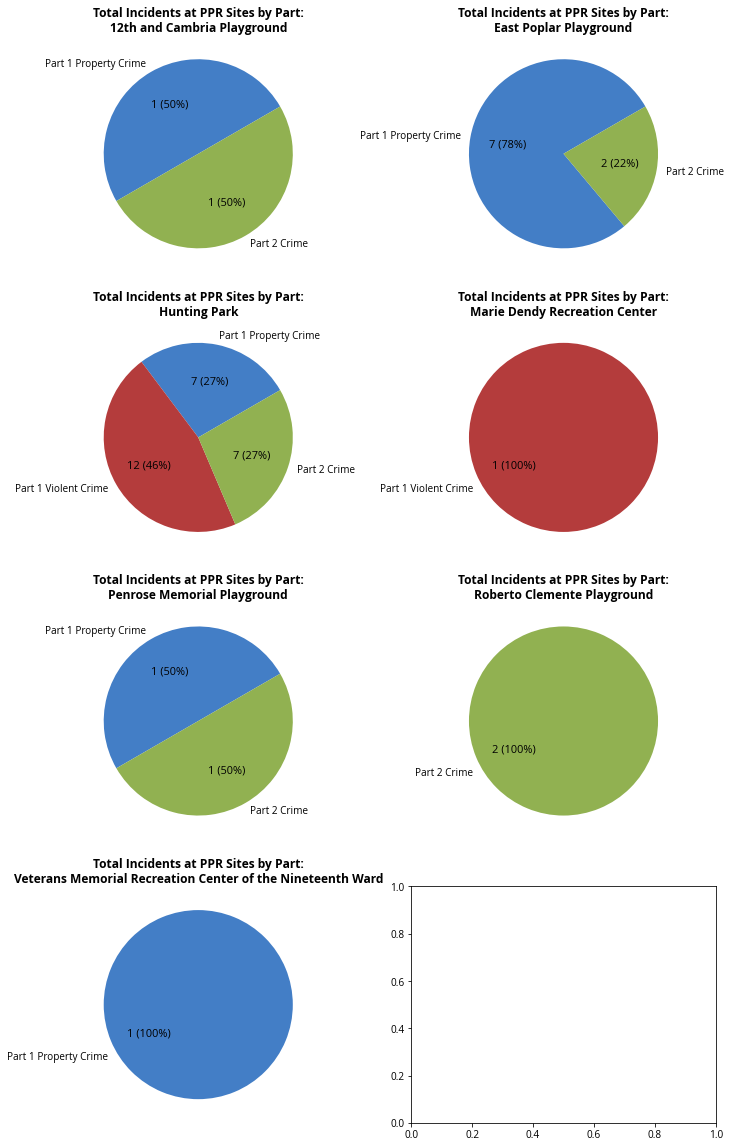

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(4, 2, figsize=(12, 20)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis5_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis5_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District5/Site_PieCharts/dis5_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [115]:
dis5_tables = sdf[sdf['COUNCIL_DISTRICT'] == '5']
# summarize incident count
dis5_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis5_tables = dis5_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis5_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,5,12th and Cambria Playground,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
1,5,12th and Cambria Playground,Part 2 Crime,Vandalism,Off-Season,Non-Active,1
2,5,East Poplar Playground,Part 1 Property Crime,Motor Vehicle Theft,Summer,Active,1
3,5,East Poplar Playground,Part 1 Property Crime,Theft,Off-Season,Active,1
4,5,East Poplar Playground,Part 1 Property Crime,Theft,Off-Season,Non-Active,3
5,5,East Poplar Playground,Part 1 Property Crime,Theft,Summer,Active,2
6,5,East Poplar Playground,Part 2 Crime,All Other Offenses,Off-Season,Active,1
7,5,East Poplar Playground,Part 2 Crime,Narcotics/Drug Law Violations,Off-Season,Active,1
8,5,Hunting Park,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Active,1
9,5,Hunting Park,Part 1 Property Crime,Motor Vehicle Theft,Off-Season,Non-Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [116]:
# create the pivot table
dis5table1 = dis5_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis5table1.reset_index(inplace=True)
dis5table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,12th and Cambria Playground,Motor Vehicle Theft,1
1,12th and Cambria Playground,Vandalism,1
2,East Poplar Playground,All Other Offenses,1
3,East Poplar Playground,Motor Vehicle Theft,1
4,East Poplar Playground,Narcotics/Drug Law Violations,1
5,East Poplar Playground,Theft,6
6,Hunting Park,Aggravated Assault,5
7,Hunting Park,All Other Offenses,2
8,Hunting Park,Disorderly Conduct,1
9,Hunting Park,Homicide,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [117]:
# create a new dataframe to calculate the total number of incidents per site
dis5table1_sum= dis5table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis5table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis5table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis5table1col = dis5table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis5table1final = pd.concat([dis5table1col, dis5table1_sum])
# our totals columns 
dis5table1final = dis5table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis5table1final['GIS_CRIME'] =np.where(dis5table1final['grand_total'].isnull(),
                             dis5table1final['GIS_CRIME'],
                             dis5table1final['grand_total'])
# remove the total column - we no longer need it
dis5table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis5table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis5table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis5table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,12th and Cambria Playground,Motor Vehicle Theft,1
1,12th and Cambria Playground,Vandalism,1
0,12th and Cambria Playground,Total Incidents,2
2,East Poplar Playground,All Other Offenses,1
3,East Poplar Playground,Motor Vehicle Theft,1
4,East Poplar Playground,Narcotics/Drug Law Violations,1
5,East Poplar Playground,Theft,6
1,East Poplar Playground,Total Incidents,9
16,Hunting Park,VUFA (Violation of the Uniform Firearm Act),1
15,Hunting Park,Theft,4


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [118]:
dict_site_5_1 = dict(iter(dis5table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_5_1: 
    with open(str(path) + '/Districts/District5/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_5_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [119]:
# set up the pivot table
dis5table2 = dis5_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis5table2.reset_index(inplace=True)
dis5table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,12th and Cambria Playground,Part 1 Property Crime,1
1,12th and Cambria Playground,Part 2 Crime,1
2,East Poplar Playground,Part 1 Property Crime,7
3,East Poplar Playground,Part 2 Crime,2
4,Hunting Park,Part 1 Property Crime,7
5,Hunting Park,Part 1 Violent Crime,12
6,Hunting Park,Part 2 Crime,7
7,Marie Dendy Recreation Center,Part 1 Violent Crime,1
8,Penrose Memorial Playground,Part 1 Property Crime,1
9,Penrose Memorial Playground,Part 2 Crime,1


In [120]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis5table2_sum= dis5table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis5table2_sum['grand_total'] ='Total Incidents'
dis5table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis5table2col = dis5table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis5table2final = pd.concat([dis5table2col, dis5table2_sum])
dis5table2final = dis5table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis5table2final['GIS_PART'] =np.where(dis5table2final['grand_total'].isnull(),
                             dis5table2final['GIS_PART'],
                             dis5table2final['grand_total'])

dis5table2final.drop(['grand_total'],axis=1,inplace=True)
dis5table2final.fillna(value=0, inplace=True)
dis5table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis5table2final.head(10)

,Site Name,Crime Type,Incident Count
0,12th and Cambria Playground,Part 1 Property Crime,1
1,12th and Cambria Playground,Part 2 Crime,1
0,12th and Cambria Playground,Total Incidents,2
2,East Poplar Playground,Part 1 Property Crime,7
3,East Poplar Playground,Part 2 Crime,2
1,East Poplar Playground,Total Incidents,9
4,Hunting Park,Part 1 Property Crime,7
5,Hunting Park,Part 1 Violent Crime,12
6,Hunting Park,Part 2 Crime,7
2,Hunting Park,Total Incidents,26


In [121]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_5_2 = dict(iter(dis5table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_5_2: 
    with open(str(path) + '/Districts/District5/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_5_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated.</b>

In [122]:
dis5table3 = dis5_tables[dis5_tables['SEASON'] == 'Summer']
dis5table3 = dis5table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis5table3.reset_index(inplace=True)
dis5table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis5table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active
0,East Poplar Playground,Motor Vehicle Theft,1
1,East Poplar Playground,Theft,2
2,Hunting Park,Aggravated Assault,2
3,Hunting Park,Motor Vehicle Theft,1
4,Penrose Memorial Playground,Theft,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [124]:
# adding in our dataframe for the site totals
dis5table3_sum= dis5table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis5table3_sum['grand_total'] ='Total Incidents'
dis5table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [125]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis5table3col = dis5table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis5table3final = pd.concat([dis5table3col, dis5table3_sum])
dis5table3final = dis5table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis5table3final['GIS_CRIME'] =np.where(dis5table3final['grand_total'].isnull(),
                             dis5table3final['GIS_CRIME'],
                             dis5table3final['grand_total'])

dis5table3final.drop(['grand_total'],axis=1,inplace=True)
dis5table3final.fillna(value=0, inplace=True)
dis5table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis5table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active
0,East Poplar Playground,Motor Vehicle Theft,1
1,East Poplar Playground,Theft,2
0,East Poplar Playground,Total Incidents,3
2,Hunting Park,Aggravated Assault,2
3,Hunting Park,Motor Vehicle Theft,1
1,Hunting Park,Total Incidents,3
4,Penrose Memorial Playground,Theft,1
2,Penrose Memorial Playground,Total Incidents,1


In [126]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_5_table3 = dict(iter(dis5table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_5_table3: 
    with open(str(path) + '/Districts/District5/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_5_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [127]:
# set up our pivot table
dis5table4 = dis5_tables[dis5_tables['SEASON'] == 'Off-Season']
dis5table4 = dis5table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis5table4.reset_index(inplace=True)
dis5table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis5table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,12th and Cambria Playground,Motor Vehicle Theft,1,0
1,12th and Cambria Playground,Vandalism,0,1
2,East Poplar Playground,All Other Offenses,1,0
3,East Poplar Playground,Narcotics/Drug Law Violations,1,0
4,East Poplar Playground,Theft,1,3
5,Hunting Park,Aggravated Assault,1,2
6,Hunting Park,All Other Offenses,0,2
7,Hunting Park,Disorderly Conduct,1,0
8,Hunting Park,Homicide,0,1
9,Hunting Park,Motor Vehicle Theft,1,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [128]:
# add the totals for each site
dis5table4_sum= dis5table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis5table4_sum['grand_total'] ='Total Incidents'
dis5table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [129]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis5table4col = dis5table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis5table4final = pd.concat([dis5table4col, dis5table4_sum])
dis5table4final = dis5table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis5table4final['GIS_CRIME'] =np.where(dis5table4final['grand_total'].isnull(),
                             dis5table4final['GIS_CRIME'],
                             dis5table4final['grand_total'])

dis5table4final.drop(['grand_total'],axis=1,inplace=True)
dis5table4final.fillna(value=0, inplace=True)
dis5table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis5table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,12th and Cambria Playground,Motor Vehicle Theft,1,0
1,12th and Cambria Playground,Vandalism,0,1
0,12th and Cambria Playground,Total Incidents,1,1
2,East Poplar Playground,All Other Offenses,1,0
3,East Poplar Playground,Narcotics/Drug Law Violations,1,0
4,East Poplar Playground,Theft,1,3
1,East Poplar Playground,Total Incidents,3,3
15,Hunting Park,VUFA (Violation of the Uniform Firearm Act),1,0
14,Hunting Park,Theft,1,3
13,Hunting Park,Simple Assault,1,0


In [130]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_5_table4 = dict(iter(dis5table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_5_table4: 
    with open(str(path) + '/Districts/District5/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_5_table4[i].to_html(classes='mystyle')))

### District 6

#### Main Summary Analysis Table

In [131]:
# filter original dataframe to see only District 1
dis6f = sdf[sdf['COUNCILDIS'] == 6] 

# summarize incident count
dis6 = dis6f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis6.pop('incident_count')
dis6.insert(1, 'incident_count', first_column) 

# rename columns
dis6.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis6 = dis6.append(dis6.sum(numeric_only=True), ignore_index=True)
dis6['Site Name'].fillna('Total Incidents in District', inplace=True)
dis6 = dis6.replace(np.nan, '', regex=True)

dis6.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,American Legion Playground,1,Part 1 Violent Crime,Aggravated Assault
1,American Legion Playground,1,Part 2 Crime,Simple Assault
2,Bridesburg Recreation Center,1,Part 2 Crime,Simple Assault
3,Holmesburg Recreation Center,1,Part 2 Crime,Simple Assault
4,James J Ramp Playground,1,Part 1 Violent Crime,Aggravated Assault
5,Joseph F Vogt Playground,1,Part 1 Property Crime,Theft
6,Torresdale Recreation Center,1,Part 1 Property Crime,Theft
7,Torresdale Recreation Center,1,Part 1 Violent Crime,Robbery
8,Victor J Moss Memorial Field,1,Part 1 Property Crime,Theft
9,Victor J Moss Memorial Field,1,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act)


In [132]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District6/Dis_OverviewPage/dis6summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis6.to_html(classes='mystyle')))

#### Main Pivot Table

In [133]:
# shape pivot table and add total column and row
dis6_pivot = dis6f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis6_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis6_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,2,,2
1,Robbery,,1,,1
2,Simple Assault,,,3,3
3,Theft,3,,,3
4,VUFA (Violation of the Uniform Firearm Act),,,1,1
5,Total,3,3,4,10


In [134]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District6/Dis_OverviewPage/dis6pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis6_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [135]:
# for the pie chart
dis6pie = dis6f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [136]:
dis6_sites = sdf[sdf['COUNCIL_DISTRICT'] == '6']
# summarize incident count
dis6_sites['incident_count_new'] = dis6_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis6_sites = dis6_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis6_sites = dis6_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis6_sites.reset_index(inplace=True)
print(dis6_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

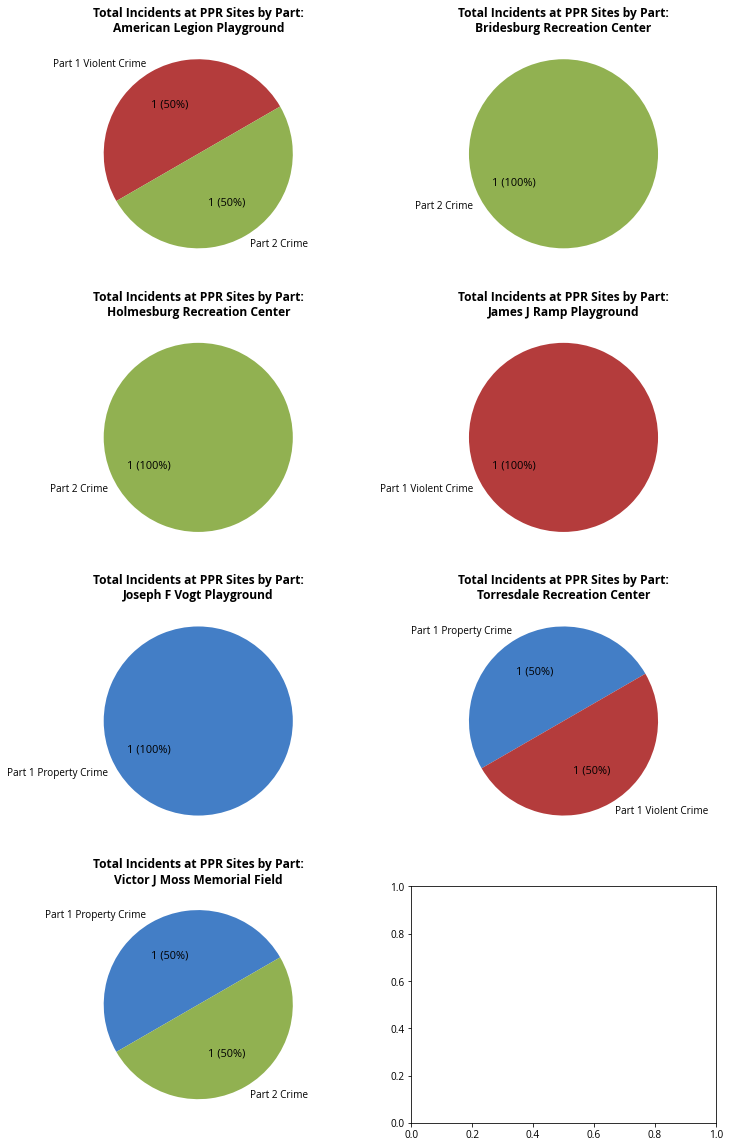

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(4, 2, figsize=(12, 20)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis6_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis6_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District6/Site_PieCharts/dis6_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [139]:
dis6_tables = sdf[sdf['COUNCIL_DISTRICT'] == '6']
# summarize incident count
dis6_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis6_tables = dis6_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis6_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,6,American Legion Playground,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
1,6,American Legion Playground,Part 2 Crime,Simple Assault,Off-Season,Active,1
2,6,Bridesburg Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Active,1
3,6,Holmesburg Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Active,1
4,6,James J Ramp Playground,Part 1 Violent Crime,Aggravated Assault,Off-Season,Non-Active,1
5,6,Joseph F Vogt Playground,Part 1 Property Crime,Theft,Off-Season,Active,1
6,6,Torresdale Recreation Center,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
7,6,Torresdale Recreation Center,Part 1 Violent Crime,Robbery,Off-Season,Active,1
8,6,Victor J Moss Memorial Field,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
9,6,Victor J Moss Memorial Field,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act),Off-Season,Active,1


##### Table 1

In [140]:
# create the pivot table
dis6table1 = dis6_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis6table1.reset_index(inplace=True)
dis6table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,American Legion Playground,Aggravated Assault,1
1,American Legion Playground,Simple Assault,1
2,Bridesburg Recreation Center,Simple Assault,1
3,Holmesburg Recreation Center,Simple Assault,1
4,James J Ramp Playground,Aggravated Assault,1
5,Joseph F Vogt Playground,Theft,1
6,Torresdale Recreation Center,Robbery,1
7,Torresdale Recreation Center,Theft,1
8,Victor J Moss Memorial Field,Theft,1
9,Victor J Moss Memorial Field,VUFA (Violation of the Uniform Firearm Act),1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [141]:
# create a new dataframe to calculate the total number of incidents per site
dis6table1_sum= dis6table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis6table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis6table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis6table1col = dis6table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis6table1final = pd.concat([dis6table1col, dis6table1_sum])
# our totals columns 
dis6table1final = dis6table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis6table1final['GIS_CRIME'] =np.where(dis6table1final['grand_total'].isnull(),
                             dis6table1final['GIS_CRIME'],
                             dis6table1final['grand_total'])
# remove the total column - we no longer need it
dis6table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis6table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis6table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis6table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,American Legion Playground,Aggravated Assault,1
1,American Legion Playground,Simple Assault,1
0,American Legion Playground,Total Incidents,2
2,Bridesburg Recreation Center,Simple Assault,1
1,Bridesburg Recreation Center,Total Incidents,1
3,Holmesburg Recreation Center,Simple Assault,1
2,Holmesburg Recreation Center,Total Incidents,1
4,James J Ramp Playground,Aggravated Assault,1
3,James J Ramp Playground,Total Incidents,1
5,Joseph F Vogt Playground,Theft,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [142]:
dict_site_6_1 = dict(iter(dis6table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_6_1: 
    with open(str(path) + '/Districts/District6/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_6_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [143]:
# set up the pivot table
dis6table2 = dis6_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis6table2.reset_index(inplace=True)
dis6table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,American Legion Playground,Part 1 Violent Crime,1
1,American Legion Playground,Part 2 Crime,1
2,Bridesburg Recreation Center,Part 2 Crime,1
3,Holmesburg Recreation Center,Part 2 Crime,1
4,James J Ramp Playground,Part 1 Violent Crime,1
5,Joseph F Vogt Playground,Part 1 Property Crime,1
6,Torresdale Recreation Center,Part 1 Property Crime,1
7,Torresdale Recreation Center,Part 1 Violent Crime,1
8,Victor J Moss Memorial Field,Part 1 Property Crime,1
9,Victor J Moss Memorial Field,Part 2 Crime,1


In [144]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis6table2_sum= dis6table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis6table2_sum['grand_total'] ='Total Incidents'
dis6table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis6table2col = dis6table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis6table2final = pd.concat([dis6table2col, dis6table2_sum])
dis6table2final = dis6table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis6table2final['GIS_PART'] =np.where(dis6table2final['grand_total'].isnull(),
                             dis6table2final['GIS_PART'],
                             dis6table2final['grand_total'])

dis6table2final.drop(['grand_total'],axis=1,inplace=True)
dis6table2final.fillna(value=0, inplace=True)
dis6table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis6table2final.head(10)

,Site Name,Crime Type,Incident Count
0,American Legion Playground,Part 1 Violent Crime,1
1,American Legion Playground,Part 2 Crime,1
0,American Legion Playground,Total Incidents,2
2,Bridesburg Recreation Center,Part 2 Crime,1
1,Bridesburg Recreation Center,Total Incidents,1
3,Holmesburg Recreation Center,Part 2 Crime,1
2,Holmesburg Recreation Center,Total Incidents,1
4,James J Ramp Playground,Part 1 Violent Crime,1
3,James J Ramp Playground,Total Incidents,1
5,Joseph F Vogt Playground,Part 1 Property Crime,1


In [145]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_6_2 = dict(iter(dis6table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_6_2: 
    with open(str(path) + '/Districts/District6/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_6_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated with the following cell blocks.</b>

In [146]:
dis6table3 = dis6_tables[dis6_tables['SEASON'] == 'Summer']
dis6table3 = dis6table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis6table3.reset_index(inplace=True)
dis6table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis6table3.head(10)

,PUBLIC_NAME,GIS_CRIME
ACTIVE_HOURS,,


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [ ]:
# adding in our dataframe for the site totals
dis6table3_sum= dis6table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis6table3_sum['grand_total'] ='Total Incidents'
dis6table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [ ]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis6table3col = dis6table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis6table3final = pd.concat([dis6table3col, dis6table3_sum])
dis6table3final = dis6table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis6table3final['GIS_CRIME'] =np.where(dis6table3final['grand_total'].isnull(),
                             dis6table3final['GIS_CRIME'],
                             dis6table3final['grand_total'])

dis6table3final.drop(['grand_total'],axis=1,inplace=True)
dis6table3final.fillna(value=0, inplace=True)
# TEMPORARY FIX below - had issues with the total row displaying 00 for 0 + 0 in active/non-active columns - keep adding zeroes to replace values if getting this issue
dis6table3final.replace(['00', '000', '0000', '00000', '000000', '0000000', '00000000'], '0', inplace = True)
dis6table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis6table3final.head(50)

In [ ]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_6_table3 = dict(iter(dis6table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_6_table3: 
    with open(str(path) + '/Districts/District6/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_6_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [147]:
# set up our pivot table
dis6table4 = dis6_tables[dis6_tables['SEASON'] == 'Off-Season']
dis6table4 = dis6table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis6table4.reset_index(inplace=True)
dis6table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis6table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,American Legion Playground,Aggravated Assault,1,0
1,American Legion Playground,Simple Assault,1,0
2,Bridesburg Recreation Center,Simple Assault,1,0
3,Holmesburg Recreation Center,Simple Assault,1,0
4,James J Ramp Playground,Aggravated Assault,0,1
5,Joseph F Vogt Playground,Theft,1,0
6,Torresdale Recreation Center,Robbery,1,0
7,Torresdale Recreation Center,Theft,0,1
8,Victor J Moss Memorial Field,Theft,0,1
9,Victor J Moss Memorial Field,VUFA (Violation of the Uniform Firearm Act),1,0


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [148]:
# add the totals for each site
dis6table4_sum= dis6table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis6table4_sum['grand_total'] ='Total Incidents'
dis6table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [149]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis6table4col = dis6table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis6table4final = pd.concat([dis6table4col, dis6table4_sum])
dis6table4final = dis6table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis6table4final['GIS_CRIME'] =np.where(dis6table4final['grand_total'].isnull(),
                             dis6table4final['GIS_CRIME'],
                             dis6table4final['grand_total'])

dis6table4final.drop(['grand_total'],axis=1,inplace=True)
dis6table4final.fillna(value=0, inplace=True)
dis6table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis6table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Non-Active
0,American Legion Playground,Aggravated Assault,0
1,American Legion Playground,Simple Assault,0
0,American Legion Playground,Total Incidents,0
2,Bridesburg Recreation Center,Simple Assault,0
1,Bridesburg Recreation Center,Total Incidents,0
3,Holmesburg Recreation Center,Simple Assault,0
2,Holmesburg Recreation Center,Total Incidents,0
4,James J Ramp Playground,Aggravated Assault,1
3,James J Ramp Playground,Total Incidents,1
5,Joseph F Vogt Playground,Theft,0


In [150]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_6_table4 = dict(iter(dis6table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_6_table4: 
    with open(str(path) + '/Districts/District6/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_6_table4[i].to_html(classes='mystyle')))

### District 7

#### Main Summary Analysis Table

In [151]:
# filter original dataframe to see only District 1
dis7f = sdf[sdf['COUNCILDIS'] == 7] 

# summarize incident count
dis7 = dis7f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis7.pop('incident_count')
dis7.insert(1, 'incident_count', first_column) 

# rename columns
dis7.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis7 = dis7.append(dis7.sum(numeric_only=True), ignore_index=True)
dis7['Site Name'].fillna('Total Incidents in District', inplace=True)
dis7 = dis7.replace(np.nan, '', regex=True)

dis7.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Carmella A DiTizio Playground,1,Part 1 Property Crime,Theft
1,Carmella A DiTizio Playground,1,Part 2 Crime,Disorderly Conduct
2,Carmella A DiTizio Playground,2,Part 2 Crime,Other Sex Offenses
3,Dan Shissler Recreation Center,3,Part 1 Property Crime,Theft
4,Dan Shissler Recreation Center,1,Part 1 Violent Crime,Aggravated Assault
5,Dan Shissler Recreation Center,1,Part 1 Violent Crime,Robbery
6,Frank S Nelson Jr Memorial Recreation Center,1,Part 2 Crime,Simple Assault
7,Gerald J Maguire Playground,1,Part 2 Crime,Simple Assault
8,Joseph C McIlvain Playground,1,Part 1 Property Crime,Motor Vehicle Theft
9,Joseph C McIlvain Playground,2,Part 1 Violent Crime,Robbery


In [152]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District7/Dis_OverviewPage/dis7summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis7.to_html(classes='mystyle')))

#### Main Pivot Table

In [153]:
# shape pivot table and add total column and row
dis7_pivot = dis7f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis7_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis7_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,5,,5
1,All Other Offenses,,,3,3
2,Burglary,2,,,2
3,Disorderly Conduct,,,2,2
4,Driving Under the Influence (DUI),,,1,1
5,Motor Vehicle Theft,3,,,3
6,Narcotics/Drug Law Violations,,,5,5
7,Other Sex Offenses,,,2,2
8,Robbery,,5,,5
9,Simple Assault,,,8,8


In [154]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District7/Dis_OverviewPage/dis7pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis7_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [155]:
# for the pie chart
dis7pie = dis7f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [156]:
dis7_sites = sdf[sdf['COUNCIL_DISTRICT'] == '7']
# summarize incident count
dis7_sites['incident_count_new'] = dis7_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis7_sites = dis7_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis7_sites = dis7_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis7_sites.reset_index(inplace=True)
print(dis7_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


13


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

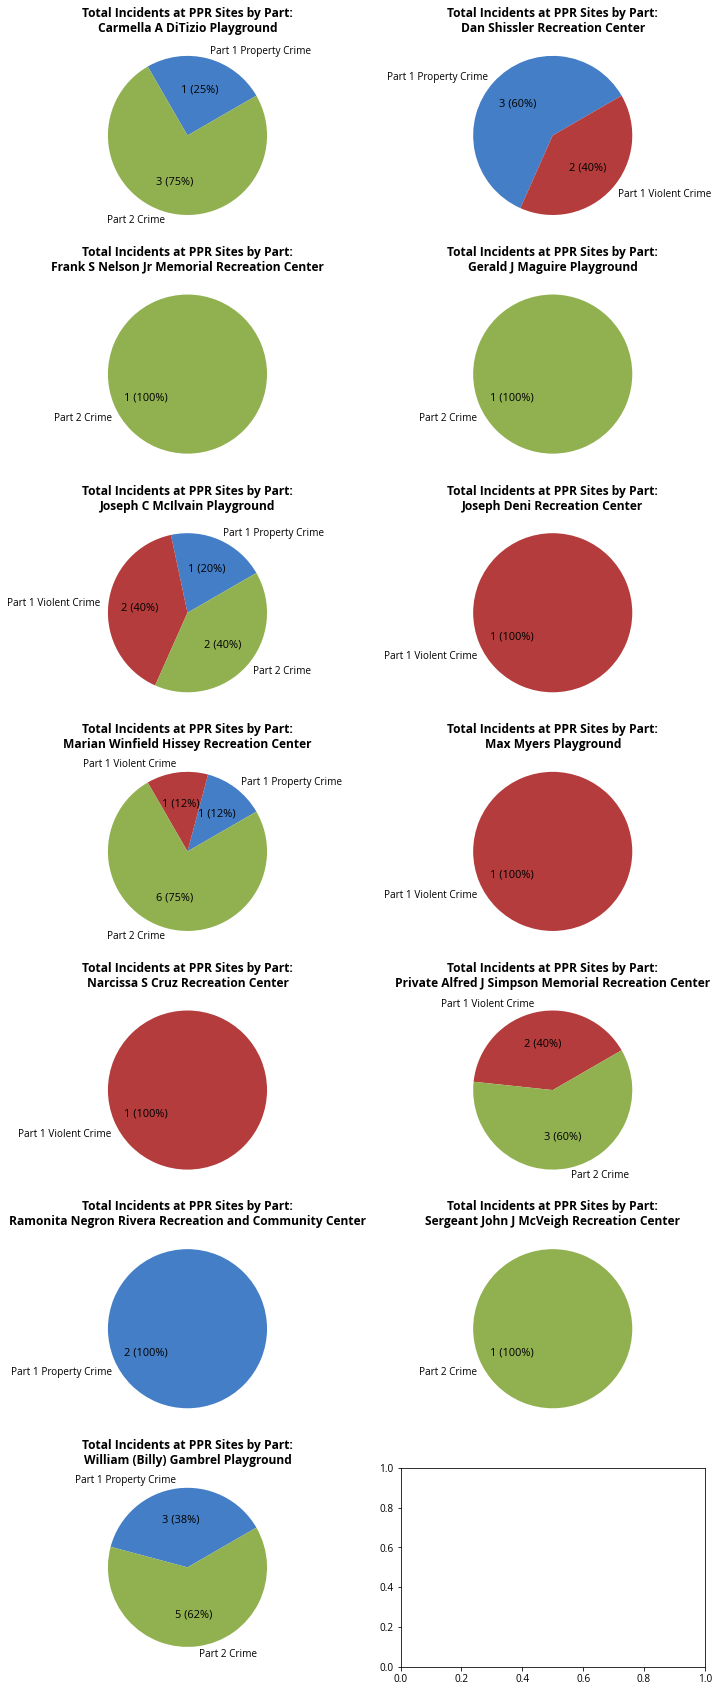

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(7, 2, figsize=(12, 30)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis7_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis7_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District7/Site_PieCharts/dis7_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [159]:
dis7_tables = sdf[sdf['COUNCIL_DISTRICT'] == '7']
# summarize incident count
dis7_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis7_tables = dis7_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis7_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,7,Carmella A DiTizio Playground,Part 1 Property Crime,Theft,Off-Season,Active,1
1,7,Carmella A DiTizio Playground,Part 2 Crime,Disorderly Conduct,Off-Season,Active,1
2,7,Carmella A DiTizio Playground,Part 2 Crime,Other Sex Offenses,Off-Season,Active,2
3,7,Dan Shissler Recreation Center,Part 1 Property Crime,Theft,Off-Season,Active,1
4,7,Dan Shissler Recreation Center,Part 1 Property Crime,Theft,Summer,Active,1
5,7,Dan Shissler Recreation Center,Part 1 Property Crime,Theft,Summer,Non-Active,1
6,7,Dan Shissler Recreation Center,Part 1 Violent Crime,Aggravated Assault,Summer,Non-Active,1
7,7,Dan Shissler Recreation Center,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,1
8,7,Frank S Nelson Jr Memorial Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Active,1
9,7,Gerald J Maguire Playground,Part 2 Crime,Simple Assault,Off-Season,Non-Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [160]:
# create the pivot table
dis7table1 = dis7_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis7table1.reset_index(inplace=True)
dis7table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,Carmella A DiTizio Playground,Disorderly Conduct,1
1,Carmella A DiTizio Playground,Other Sex Offenses,2
2,Carmella A DiTizio Playground,Theft,1
3,Dan Shissler Recreation Center,Aggravated Assault,1
4,Dan Shissler Recreation Center,Robbery,1
5,Dan Shissler Recreation Center,Theft,3
6,Frank S Nelson Jr Memorial Recreation Center,Simple Assault,1
7,Gerald J Maguire Playground,Simple Assault,1
8,Joseph C McIlvain Playground,Motor Vehicle Theft,1
9,Joseph C McIlvain Playground,Robbery,2


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [161]:
# create a new dataframe to calculate the total number of incidents per site
dis7table1_sum= dis7table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis7table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis7table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis7table1col = dis7table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis7table1final = pd.concat([dis7table1col, dis7table1_sum])
# our totals columns 
dis7table1final = dis7table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis7table1final['GIS_CRIME'] =np.where(dis7table1final['grand_total'].isnull(),
                             dis7table1final['GIS_CRIME'],
                             dis7table1final['grand_total'])
# remove the total column - we no longer need it
dis7table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis7table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis7table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis7table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Carmella A DiTizio Playground,Disorderly Conduct,1
1,Carmella A DiTizio Playground,Other Sex Offenses,2
2,Carmella A DiTizio Playground,Theft,1
0,Carmella A DiTizio Playground,Total Incidents,4
3,Dan Shissler Recreation Center,Aggravated Assault,1
4,Dan Shissler Recreation Center,Robbery,1
5,Dan Shissler Recreation Center,Theft,3
1,Dan Shissler Recreation Center,Total Incidents,5
6,Frank S Nelson Jr Memorial Recreation Center,Simple Assault,1
2,Frank S Nelson Jr Memorial Recreation Center,Total Incidents,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [162]:
dict_site_7_1 = dict(iter(dis7table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_7_1: 
    with open(str(path) + '/Districts/District7/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_7_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [163]:
# set up the pivot table
dis7table2 = dis7_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis7table2.reset_index(inplace=True)
dis7table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,Carmella A DiTizio Playground,Part 1 Property Crime,1
1,Carmella A DiTizio Playground,Part 2 Crime,3
2,Dan Shissler Recreation Center,Part 1 Property Crime,3
3,Dan Shissler Recreation Center,Part 1 Violent Crime,2
4,Frank S Nelson Jr Memorial Recreation Center,Part 2 Crime,1
5,Gerald J Maguire Playground,Part 2 Crime,1
6,Joseph C McIlvain Playground,Part 1 Property Crime,1
7,Joseph C McIlvain Playground,Part 1 Violent Crime,2
8,Joseph C McIlvain Playground,Part 2 Crime,2
9,Joseph Deni Recreation Center,Part 1 Violent Crime,1


In [164]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis7table2_sum= dis7table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis7table2_sum['grand_total'] ='Total Incidents'
dis7table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis7table2col = dis7table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis7table2final = pd.concat([dis7table2col, dis7table2_sum])
dis7table2final = dis7table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis7table2final['GIS_PART'] =np.where(dis7table2final['grand_total'].isnull(),
                             dis7table2final['GIS_PART'],
                             dis7table2final['grand_total'])

dis7table2final.drop(['grand_total'],axis=1,inplace=True)
dis7table2final.fillna(value=0, inplace=True)
dis7table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis7table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Carmella A DiTizio Playground,Part 1 Property Crime,1
1,Carmella A DiTizio Playground,Part 2 Crime,3
0,Carmella A DiTizio Playground,Total Incidents,4
2,Dan Shissler Recreation Center,Part 1 Property Crime,3
3,Dan Shissler Recreation Center,Part 1 Violent Crime,2
1,Dan Shissler Recreation Center,Total Incidents,5
4,Frank S Nelson Jr Memorial Recreation Center,Part 2 Crime,1
2,Frank S Nelson Jr Memorial Recreation Center,Total Incidents,1
5,Gerald J Maguire Playground,Part 2 Crime,1
3,Gerald J Maguire Playground,Total Incidents,1


In [165]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_7_2 = dict(iter(dis7table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_7_2: 
    with open(str(path) + '/Districts/District7/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_7_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated with the following cell blocks.</b>

In [166]:
dis7table3 = dis7_tables[dis7_tables['SEASON'] == 'Summer']
dis7table3 = dis7table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis7table3.reset_index(inplace=True)
dis7table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis7table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Dan Shissler Recreation Center,Aggravated Assault,0,1
1,Dan Shissler Recreation Center,Theft,1,1
2,Joseph C McIlvain Playground,Robbery,0,1
3,Max Myers Playground,Robbery,0,1
4,Private Alfred J Simpson Memorial Recreation C...,Disorderly Conduct,1,0
5,Private Alfred J Simpson Memorial Recreation C...,Simple Assault,2,0
6,William (Billy) Gambrel Playground,All Other Offenses,0,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [167]:
# adding in our dataframe for the site totals
dis7table3_sum= dis7table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis7table3_sum['grand_total'] ='Total Incidents'
dis7table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [168]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis7table3col = dis7table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis7table3final = pd.concat([dis7table3col, dis7table3_sum])
dis7table3final = dis7table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis7table3final['GIS_CRIME'] =np.where(dis7table3final['grand_total'].isnull(),
                             dis7table3final['GIS_CRIME'],
                             dis7table3final['grand_total'])

dis7table3final.drop(['grand_total'],axis=1,inplace=True)
dis7table3final.fillna(value=0, inplace=True)
dis7table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis7table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active,Non-Active
0,Dan Shissler Recreation Center,Aggravated Assault,0,1
1,Dan Shissler Recreation Center,Theft,1,1
0,Dan Shissler Recreation Center,Total Incidents,1,2
2,Joseph C McIlvain Playground,Robbery,0,1
1,Joseph C McIlvain Playground,Total Incidents,0,1
3,Max Myers Playground,Robbery,0,1
2,Max Myers Playground,Total Incidents,0,1
4,Private Alfred J Simpson Memorial Recreation C...,Disorderly Conduct,1,0
5,Private Alfred J Simpson Memorial Recreation C...,Simple Assault,2,0
3,Private Alfred J Simpson Memorial Recreation C...,Total Incidents,3,0


In [169]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_7_table3 = dict(iter(dis7table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_7_table3: 
    with open(str(path) + '/Districts/District7/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_7_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [170]:
# set up our pivot table
dis7table4 = dis7_tables[dis7_tables['SEASON'] == 'Off-Season']
dis7table4 = dis7table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis7table4.reset_index(inplace=True)
dis7table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis7table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Carmella A DiTizio Playground,Disorderly Conduct,1,0
1,Carmella A DiTizio Playground,Other Sex Offenses,2,0
2,Carmella A DiTizio Playground,Theft,1,0
3,Dan Shissler Recreation Center,Robbery,0,1
4,Dan Shissler Recreation Center,Theft,1,0
5,Frank S Nelson Jr Memorial Recreation Center,Simple Assault,1,0
6,Gerald J Maguire Playground,Simple Assault,0,1
7,Joseph C McIlvain Playground,Motor Vehicle Theft,1,0
8,Joseph C McIlvain Playground,Robbery,1,0
9,Joseph C McIlvain Playground,Simple Assault,1,0


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [171]:
# add the totals for each site
dis7table4_sum= dis7table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis7table4_sum['grand_total'] ='Total Incidents'
dis7table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [172]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis7table4col = dis7table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis7table4final = pd.concat([dis7table4col, dis7table4_sum])
dis7table4final = dis7table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis7table4final['GIS_CRIME'] =np.where(dis7table4final['grand_total'].isnull(),
                             dis7table4final['GIS_CRIME'],
                             dis7table4final['grand_total'])

dis7table4final.drop(['grand_total'],axis=1,inplace=True)
dis7table4final.fillna(value=0, inplace=True)
dis7table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis7table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Carmella A DiTizio Playground,Disorderly Conduct,1,0
1,Carmella A DiTizio Playground,Other Sex Offenses,2,0
2,Carmella A DiTizio Playground,Theft,1,0
0,Carmella A DiTizio Playground,Total Incidents,4,0
3,Dan Shissler Recreation Center,Robbery,0,1
4,Dan Shissler Recreation Center,Theft,1,0
1,Dan Shissler Recreation Center,Total Incidents,1,1
5,Frank S Nelson Jr Memorial Recreation Center,Simple Assault,1,0
2,Frank S Nelson Jr Memorial Recreation Center,Total Incidents,1,0
6,Gerald J Maguire Playground,Simple Assault,0,1


In [173]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_7_table4 = dict(iter(dis7table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_7_table4: 
    with open(str(path) + '/Districts/District7/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_7_table4[i].to_html(classes='mystyle')))

### District 8

#### Main Summary Analysis Table

In [174]:
# filter original dataframe to see only District 1
dis8f = sdf[sdf['COUNCILDIS'] == 8] 

# summarize incident count
dis8 = dis8f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis8.pop('incident_count')
dis8.insert(1, 'incident_count', first_column) 

# rename columns
dis8.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis8 = dis8.append(dis8.sum(numeric_only=True), ignore_index=True)
dis8['Site Name'].fillna('Total Incidents in District', inplace=True)
dis8 = dis8.replace(np.nan, '', regex=True)

dis8.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,22nd and Ontario Park,1,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act)
1,Awbury Park and Recreation Center,1,Part 1 Property Crime,Theft
2,Fernhill Park,2,Part 1 Property Crime,Theft
3,Fernhill Park,1,Part 2 Crime,Disorderly Conduct
4,Lonnie Young Recreation Center of East Germantown,1,Part 1 Property Crime,Theft
5,Lonnie Young Recreation Center of East Germantown,1,Part 2 Crime,Narcotics/Drug Law Violations
6,Lonnie Young Recreation Center of East Germantown,2,Part 2 Crime,Simple Assault
7,Lonnie Young Recreation Center of East Germantown,1,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act)
8,Morris Estate Cultural Center,3,Part 2 Crime,Simple Assault
9,Morton Playground,1,Part 2 Crime,Vandalism


In [175]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District8/Dis_OverviewPage/dis8summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis8.to_html(classes='mystyle')))

#### Main Pivot Table

In [176]:
# shape pivot table and add total column and row
dis8_pivot = dis8f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis8_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis8_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Burglary,1,,,1
1,Disorderly Conduct,,,1,1
2,Narcotics/Drug Law Violations,,,6,6
3,Other Sex Offenses,,,2,2
4,Robbery,,1,,1
5,Simple Assault,,,6,6
6,Theft,5,,,5
7,VUFA (Violation of the Uniform Firearm Act),,,3,3
8,Vandalism,,,3,3
9,Total,6,1,21,28


In [177]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District8/Dis_OverviewPage/dis8pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis8_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [178]:
# for the pie chart
dis8pie = dis8f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [179]:
dis8_sites = sdf[sdf['COUNCIL_DISTRICT'] == '8']
# summarize incident count
dis8_sites['incident_count_new'] = dis8_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis8_sites = dis8_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis8_sites = dis8_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis8_sites.reset_index(inplace=True)
print(dis8_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

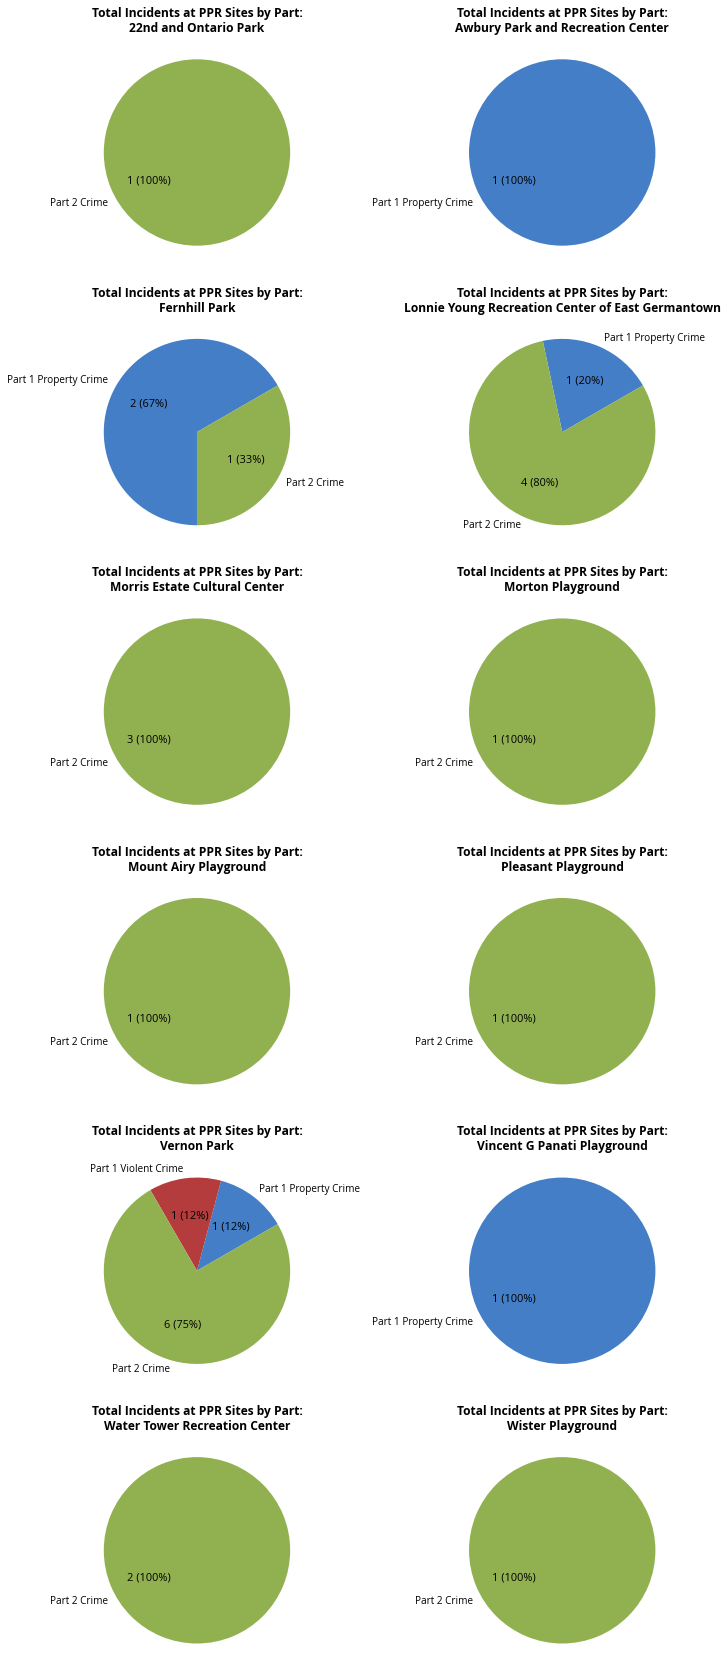

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(6, 2, figsize=(12, 30)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis8_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis8_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District8/Site_PieCharts/dis8_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [181]:
dis8_tables = sdf[sdf['COUNCIL_DISTRICT'] == '8']
# summarize incident count
dis8_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis8_tables = dis8_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis8_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,8,22nd and Ontario Park,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act),Off-Season,Active,1
1,8,Awbury Park and Recreation Center,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
2,8,Fernhill Park,Part 1 Property Crime,Theft,Off-Season,Active,1
3,8,Fernhill Park,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
4,8,Fernhill Park,Part 2 Crime,Disorderly Conduct,Off-Season,Active,1
5,8,Lonnie Young Recreation Center of East Germantown,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
6,8,Lonnie Young Recreation Center of East Germantown,Part 2 Crime,Narcotics/Drug Law Violations,Off-Season,Active,1
7,8,Lonnie Young Recreation Center of East Germantown,Part 2 Crime,Simple Assault,Off-Season,Active,2
8,8,Lonnie Young Recreation Center of East Germantown,Part 2 Crime,VUFA (Violation of the Uniform Firearm Act),Off-Season,Active,1
9,8,Morris Estate Cultural Center,Part 2 Crime,Simple Assault,Off-Season,Active,2


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [182]:
# create the pivot table
dis8table1 = dis8_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis8table1.reset_index(inplace=True)
dis8table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,22nd and Ontario Park,VUFA (Violation of the Uniform Firearm Act),1
1,Awbury Park and Recreation Center,Theft,1
2,Fernhill Park,Disorderly Conduct,1
3,Fernhill Park,Theft,2
4,Lonnie Young Recreation Center of East Germantown,Narcotics/Drug Law Violations,1
5,Lonnie Young Recreation Center of East Germantown,Simple Assault,2
6,Lonnie Young Recreation Center of East Germantown,Theft,1
7,Lonnie Young Recreation Center of East Germantown,VUFA (Violation of the Uniform Firearm Act),1
8,Morris Estate Cultural Center,Simple Assault,3
9,Morton Playground,Vandalism,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [183]:
# create a new dataframe to calculate the total number of incidents per site
dis8table1_sum= dis8table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis8table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis8table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis8table1col = dis8table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis8table1final = pd.concat([dis8table1col, dis8table1_sum])
# our totals columns 
dis8table1final = dis8table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis8table1final['GIS_CRIME'] =np.where(dis8table1final['grand_total'].isnull(),
                             dis8table1final['GIS_CRIME'],
                             dis8table1final['grand_total'])
# remove the total column - we no longer need it
dis8table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis8table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis8table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis8table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,22nd and Ontario Park,VUFA (Violation of the Uniform Firearm Act),1
0,22nd and Ontario Park,Total Incidents,1
1,Awbury Park and Recreation Center,Theft,1
1,Awbury Park and Recreation Center,Total Incidents,1
2,Fernhill Park,Disorderly Conduct,1
3,Fernhill Park,Theft,2
2,Fernhill Park,Total Incidents,3
4,Lonnie Young Recreation Center of East Germantown,Narcotics/Drug Law Violations,1
5,Lonnie Young Recreation Center of East Germantown,Simple Assault,2
6,Lonnie Young Recreation Center of East Germantown,Theft,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [184]:
dict_site_8_1 = dict(iter(dis8table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_8_1: 
    with open(str(path) + '/Districts/District8/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_8_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [185]:
# set up the pivot table
dis8table2 = dis8_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis8table2.reset_index(inplace=True)
dis8table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,22nd and Ontario Park,Part 2 Crime,1
1,Awbury Park and Recreation Center,Part 1 Property Crime,1
2,Fernhill Park,Part 1 Property Crime,2
3,Fernhill Park,Part 2 Crime,1
4,Lonnie Young Recreation Center of East Germantown,Part 1 Property Crime,1
5,Lonnie Young Recreation Center of East Germantown,Part 2 Crime,4
6,Morris Estate Cultural Center,Part 2 Crime,3
7,Morton Playground,Part 2 Crime,1
8,Mount Airy Playground,Part 2 Crime,1
9,Pleasant Playground,Part 2 Crime,1


In [186]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis8table2_sum= dis8table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis8table2_sum['grand_total'] ='Total Incidents'
dis8table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis8table2col = dis8table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis8table2final = pd.concat([dis8table2col, dis8table2_sum])
dis8table2final = dis8table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis8table2final['GIS_PART'] =np.where(dis8table2final['grand_total'].isnull(),
                             dis8table2final['GIS_PART'],
                             dis8table2final['grand_total'])

dis8table2final.drop(['grand_total'],axis=1,inplace=True)
dis8table2final.fillna(value=0, inplace=True)
dis8table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis8table2final.head(10)

,Site Name,Crime Type,Incident Count
0,22nd and Ontario Park,Part 2 Crime,1
0,22nd and Ontario Park,Total Incidents,1
1,Awbury Park and Recreation Center,Part 1 Property Crime,1
1,Awbury Park and Recreation Center,Total Incidents,1
2,Fernhill Park,Part 1 Property Crime,2
3,Fernhill Park,Part 2 Crime,1
2,Fernhill Park,Total Incidents,3
4,Lonnie Young Recreation Center of East Germantown,Part 1 Property Crime,1
5,Lonnie Young Recreation Center of East Germantown,Part 2 Crime,4
3,Lonnie Young Recreation Center of East Germantown,Total Incidents,5


In [187]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_8_2 = dict(iter(dis8table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_8_2: 
    with open(str(path) + '/Districts/District8/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_8_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated with the following cell blocks.</b>

In [188]:
dis8table3 = dis8_tables[dis8_tables['SEASON'] == 'Summer']
dis8table3 = dis8table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis8table3.reset_index(inplace=True)
dis8table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis8table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active
0,Mount Airy Playground,Other Sex Offenses,1
1,Vernon Park,Robbery,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [190]:
# adding in our dataframe for the site totals
dis8table3_sum= dis8table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis8table3_sum['grand_total'] ='Total Incidents'
dis8table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [191]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis8table3col = dis8table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis8table3final = pd.concat([dis8table3col, dis8table3_sum])
dis8table3final = dis8table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis8table3final['GIS_CRIME'] =np.where(dis8table3final['grand_total'].isnull(),
                             dis8table3final['GIS_CRIME'],
                             dis8table3final['grand_total'])

dis8table3final.drop(['grand_total'],axis=1,inplace=True)
dis8table3final.fillna(value=0, inplace=True)
dis8table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis8table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active
0,Mount Airy Playground,Other Sex Offenses,1
0,Mount Airy Playground,Total Incidents,1
1,Vernon Park,Robbery,1
1,Vernon Park,Total Incidents,1


In [192]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_8_table3 = dict(iter(dis8table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_8_table3: 
    with open(str(path) + '/Districts/District8/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_8_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [193]:
# set up our pivot table
dis8table4 = dis8_tables[dis8_tables['SEASON'] == 'Off-Season']
dis8table4 = dis8table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis8table4.reset_index(inplace=True)
dis8table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis8table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,22nd and Ontario Park,VUFA (Violation of the Uniform Firearm Act),1,0
1,Awbury Park and Recreation Center,Theft,0,1
2,Fernhill Park,Disorderly Conduct,1,0
3,Fernhill Park,Theft,1,1
4,Lonnie Young Recreation Center of East Germantown,Narcotics/Drug Law Violations,1,0
5,Lonnie Young Recreation Center of East Germantown,Simple Assault,2,0
6,Lonnie Young Recreation Center of East Germantown,Theft,0,1
7,Lonnie Young Recreation Center of East Germantown,VUFA (Violation of the Uniform Firearm Act),1,0
8,Morris Estate Cultural Center,Simple Assault,2,1
9,Morton Playground,Vandalism,1,0


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [194]:
# add the totals for each site
dis8table4_sum= dis8table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis8table4_sum['grand_total'] ='Total Incidents'
dis8table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [195]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis8table4col = dis8table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis8table4final = pd.concat([dis8table4col, dis8table4_sum])
dis8table4final = dis8table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis8table4final['GIS_CRIME'] =np.where(dis8table4final['grand_total'].isnull(),
                             dis8table4final['GIS_CRIME'],
                             dis8table4final['grand_total'])

dis8table4final.drop(['grand_total'],axis=1,inplace=True)
dis8table4final.fillna(value=0, inplace=True)
dis8table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis8table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,22nd and Ontario Park,VUFA (Violation of the Uniform Firearm Act),1,0
0,22nd and Ontario Park,Total Incidents,1,0
1,Awbury Park and Recreation Center,Theft,0,1
1,Awbury Park and Recreation Center,Total Incidents,0,1
2,Fernhill Park,Disorderly Conduct,1,0
3,Fernhill Park,Theft,1,1
2,Fernhill Park,Total Incidents,2,1
4,Lonnie Young Recreation Center of East Germantown,Narcotics/Drug Law Violations,1,0
5,Lonnie Young Recreation Center of East Germantown,Simple Assault,2,0
6,Lonnie Young Recreation Center of East Germantown,Theft,0,1


In [196]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_8_table4 = dict(iter(dis8table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_8_table4: 
   with open(str(path) + '/Districts/District8/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_8_table4[i].to_html(classes='mystyle')))

### District 9

#### Main Summary Analysis Table

In [197]:
# filter original dataframe to see only District 1
dis9f = sdf[sdf['COUNCILDIS'] == 9] 

# summarize incident count
dis9 = dis9f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis9.pop('incident_count')
dis9.insert(1, 'incident_count', first_column) 

# rename columns
dis9.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis9 = dis9.append(dis9.sum(numeric_only=True), ignore_index=True)
dis9['Site Name'].fillna('Total Incidents in District', inplace=True)
dis9 = dis9.replace(np.nan, '', regex=True)

dis9.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Dorothy Emanuel Recreation Center,1,Part 1 Property Crime,Theft
1,Dorothy Emanuel Recreation Center,2,Part 2 Crime,Simple Assault
2,Edward Houseman Playground,1,Part 2 Crime,Narcotics/Drug Law Violations
3,Helen G Sturgis Playground,1,Part 1 Property Crime,Theft
4,Helen G Sturgis Playground,1,Part 2 Crime,Simple Assault
5,Helen G Sturgis Playground,1,Part 2 Crime,Vandalism
6,Lawncrest Recreation Center,2,Part 2 Crime,All Other Offenses
7,Olney Recreation Center,1,Part 1 Property Crime,Theft
8,Seymour Tarken Recreation Center,1,Part 1 Violent Crime,Aggravated Assault
9,Thomas E Jardel Memorial Field,1,Part 2 Crime,Simple Assault


In [198]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District9/Dis_OverviewPage/dis9summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis9.to_html(classes='mystyle')))

#### Main Pivot Table

In [199]:
# shape pivot table and add total column and row
dis9_pivot = dis9f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis9_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis9_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,1,,1
1,All Other Offenses,,,2,2
2,Narcotics/Drug Law Violations,,,1,1
3,Simple Assault,,,4,4
4,Theft,3,,,3
5,Vandalism,,,1,1
6,Total,3,1,8,12


In [200]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District3/Dis_OverviewPage/dis9pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis9_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [201]:
# for the pie chart
dis9pie = dis9f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [202]:
dis9_sites = sdf[sdf['COUNCIL_DISTRICT'] == '9']
# summarize incident count
dis9_sites['incident_count_new'] = dis9_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis9_sites = dis9_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis9_sites = dis9_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis9_sites.reset_index(inplace=True)
print(dis9_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

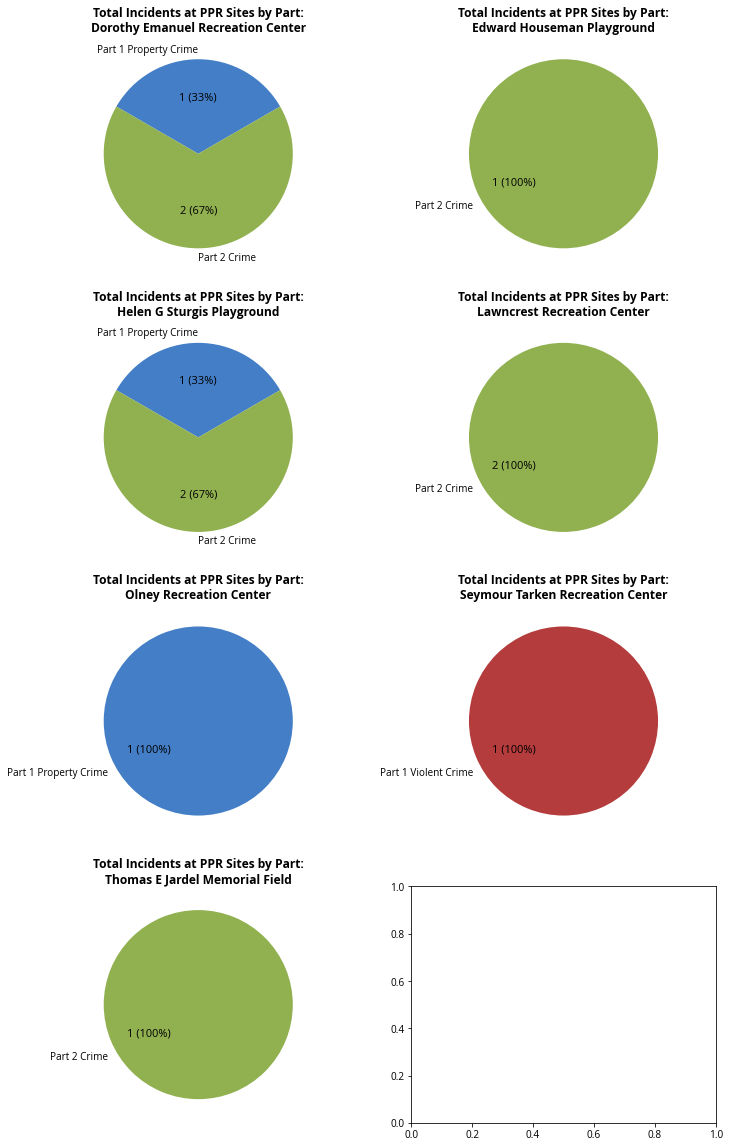

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(4, 2, figsize=(12, 20)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis9_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis9_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District9/Site_PieCharts/dis9_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [204]:
dis9_tables = sdf[sdf['COUNCIL_DISTRICT'] == '9']
# summarize incident count
dis9_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis9_tables = dis9_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis9_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,9,Dorothy Emanuel Recreation Center,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
1,9,Dorothy Emanuel Recreation Center,Part 2 Crime,Simple Assault,Off-Season,Non-Active,2
2,9,Edward Houseman Playground,Part 2 Crime,Narcotics/Drug Law Violations,Summer,Active,1
3,9,Helen G Sturgis Playground,Part 1 Property Crime,Theft,Summer,Active,1
4,9,Helen G Sturgis Playground,Part 2 Crime,Simple Assault,Off-Season,Active,1
5,9,Helen G Sturgis Playground,Part 2 Crime,Vandalism,Off-Season,Active,1
6,9,Lawncrest Recreation Center,Part 2 Crime,All Other Offenses,Off-Season,Active,1
7,9,Lawncrest Recreation Center,Part 2 Crime,All Other Offenses,Off-Season,Non-Active,1
8,9,Olney Recreation Center,Part 1 Property Crime,Theft,Off-Season,Active,1
9,9,Seymour Tarken Recreation Center,Part 1 Violent Crime,Aggravated Assault,Off-Season,Non-Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [205]:
# create the pivot table
dis9table1 = dis9_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis9table1.reset_index(inplace=True)
dis9table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,Dorothy Emanuel Recreation Center,Simple Assault,2
1,Dorothy Emanuel Recreation Center,Theft,1
2,Edward Houseman Playground,Narcotics/Drug Law Violations,1
3,Helen G Sturgis Playground,Simple Assault,1
4,Helen G Sturgis Playground,Theft,1
5,Helen G Sturgis Playground,Vandalism,1
6,Lawncrest Recreation Center,All Other Offenses,2
7,Olney Recreation Center,Theft,1
8,Seymour Tarken Recreation Center,Aggravated Assault,1
9,Thomas E Jardel Memorial Field,Simple Assault,1


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [206]:
# create a new dataframe to calculate the total number of incidents per site
dis9table1_sum= dis9table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis9table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis9table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis9table1col = dis9table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis9table1final = pd.concat([dis9table1col, dis9table1_sum])
# our totals columns 
dis9table1final = dis9table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis9table1final['GIS_CRIME'] =np.where(dis9table1final['grand_total'].isnull(),
                             dis9table1final['GIS_CRIME'],
                             dis9table1final['grand_total'])
# remove the total column - we no longer need it
dis9table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis9table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis9table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis9table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Dorothy Emanuel Recreation Center,Simple Assault,2
1,Dorothy Emanuel Recreation Center,Theft,1
0,Dorothy Emanuel Recreation Center,Total Incidents,3
2,Edward Houseman Playground,Narcotics/Drug Law Violations,1
1,Edward Houseman Playground,Total Incidents,1
3,Helen G Sturgis Playground,Simple Assault,1
4,Helen G Sturgis Playground,Theft,1
5,Helen G Sturgis Playground,Vandalism,1
2,Helen G Sturgis Playground,Total Incidents,3
6,Lawncrest Recreation Center,All Other Offenses,2


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [207]:
dict_site_9_1 = dict(iter(dis9table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_9_1: 
    with open(str(path) + '/Districts/District9/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_9_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [208]:
# set up the pivot table
dis9table2 = dis9_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis9table2.reset_index(inplace=True)
dis9table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,Dorothy Emanuel Recreation Center,Part 1 Property Crime,1
1,Dorothy Emanuel Recreation Center,Part 2 Crime,2
2,Edward Houseman Playground,Part 2 Crime,1
3,Helen G Sturgis Playground,Part 1 Property Crime,1
4,Helen G Sturgis Playground,Part 2 Crime,2
5,Lawncrest Recreation Center,Part 2 Crime,2
6,Olney Recreation Center,Part 1 Property Crime,1
7,Seymour Tarken Recreation Center,Part 1 Violent Crime,1
8,Thomas E Jardel Memorial Field,Part 2 Crime,1


In [209]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis9table2_sum= dis9table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis9table2_sum['grand_total'] ='Total Incidents'
dis9table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis9table2col = dis9table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis9table2final = pd.concat([dis9table2col, dis9table2_sum])
dis9table2final = dis9table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis9table2final['GIS_PART'] =np.where(dis9table2final['grand_total'].isnull(),
                             dis9table2final['GIS_PART'],
                             dis9table2final['grand_total'])

dis9table2final.drop(['grand_total'],axis=1,inplace=True)
dis9table2final.fillna(value=0, inplace=True)
dis9table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis9table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Dorothy Emanuel Recreation Center,Part 1 Property Crime,1
1,Dorothy Emanuel Recreation Center,Part 2 Crime,2
0,Dorothy Emanuel Recreation Center,Total Incidents,3
2,Edward Houseman Playground,Part 2 Crime,1
1,Edward Houseman Playground,Total Incidents,1
3,Helen G Sturgis Playground,Part 1 Property Crime,1
4,Helen G Sturgis Playground,Part 2 Crime,2
2,Helen G Sturgis Playground,Total Incidents,3
5,Lawncrest Recreation Center,Part 2 Crime,2
3,Lawncrest Recreation Center,Total Incidents,2


In [210]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_9_2 = dict(iter(dis9table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_9_2: 
    with open(str(path) + '/Districts/District9/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_9_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated with the following cell blocks.</b>

In [211]:
dis9table3 = dis9_tables[dis9_tables['SEASON'] == 'Summer']
dis9table3 = dis9table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis9table3.reset_index(inplace=True)
dis9table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis9table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active
0,Edward Houseman Playground,Narcotics/Drug Law Violations,1
1,Helen G Sturgis Playground,Theft,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [213]:
# adding in our dataframe for the site totals
dis9table3_sum= dis9table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis9table3_sum['grand_total'] ='Total Incidents'
dis9table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [215]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis9table3col = dis9table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis9table3final = pd.concat([dis9table3col, dis9table3_sum])
dis9table3final = dis9table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis9table3final['GIS_CRIME'] =np.where(dis9table3final['grand_total'].isnull(),
                             dis9table3final['GIS_CRIME'],
                             dis9table3final['grand_total'])

dis9table3final.drop(['grand_total'],axis=1,inplace=True)
dis9table3final.fillna(value=0, inplace=True)
dis9table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis9table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active
0,Edward Houseman Playground,Narcotics/Drug Law Violations,1
0,Edward Houseman Playground,Total Incidents,1
1,Helen G Sturgis Playground,Theft,1
1,Helen G Sturgis Playground,Total Incidents,1


In [216]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_9_table3 = dict(iter(dis9table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_9_table3: 
    with open(str(path) + '/Districts/District9/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_9_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [217]:
# set up our pivot table
dis9table4 = dis9_tables[dis9_tables['SEASON'] == 'Off-Season']
dis9table4 = dis9table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis9table4.reset_index(inplace=True)
dis9table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis9table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Dorothy Emanuel Recreation Center,Simple Assault,0,2
1,Dorothy Emanuel Recreation Center,Theft,0,1
2,Helen G Sturgis Playground,Simple Assault,1,0
3,Helen G Sturgis Playground,Vandalism,1,0
4,Lawncrest Recreation Center,All Other Offenses,1,1
5,Olney Recreation Center,Theft,1,0
6,Seymour Tarken Recreation Center,Aggravated Assault,0,1
7,Thomas E Jardel Memorial Field,Simple Assault,0,1


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [218]:
# add the totals for each site
dis9table4_sum= dis9table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis9table4_sum['grand_total'] ='Total Incidents'
dis9table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [219]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis9table4col = dis9table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis9table4final = pd.concat([dis9table4col, dis9table4_sum])
dis9table4final = dis9table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis9table4final['GIS_CRIME'] =np.where(dis9table4final['grand_total'].isnull(),
                             dis9table4final['GIS_CRIME'],
                             dis9table4final['grand_total'])

dis9table4final.drop(['grand_total'],axis=1,inplace=True)
dis9table4final.fillna(value=0, inplace=True)
dis9table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis9table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Dorothy Emanuel Recreation Center,Simple Assault,0,2
1,Dorothy Emanuel Recreation Center,Theft,0,1
0,Dorothy Emanuel Recreation Center,Total Incidents,0,3
2,Helen G Sturgis Playground,Simple Assault,1,0
3,Helen G Sturgis Playground,Vandalism,1,0
1,Helen G Sturgis Playground,Total Incidents,2,0
4,Lawncrest Recreation Center,All Other Offenses,1,1
2,Lawncrest Recreation Center,Total Incidents,1,1
5,Olney Recreation Center,Theft,1,0
3,Olney Recreation Center,Total Incidents,1,0


In [220]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_9_table4 = dict(iter(dis9table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_9_table4: 
    with open(str(path) + '/Districts/District9/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_9_table4[i].to_html(classes='mystyle')))

### District 10

#### Main Summary Analysis Table

In [221]:
# filter original dataframe to see only District 1
dis10f = sdf[sdf['COUNCILDIS'] == 10] 

# summarize incident count
dis10 = dis10f.groupby(['PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count': 'count'}).reset_index() 

# shift incident count column to second
first_column = dis10.pop('incident_count')
dis10.insert(1, 'incident_count', first_column) 

# rename columns
dis10.rename(columns = {'PUBLIC_NAME':'Site Name', 'GIS_PART':'Category', 'GIS_CRIME':'Crime Category', 'incident_count': '# of Incidents'}, inplace = True)

dis10 = dis10.append(dis10.sum(numeric_only=True), ignore_index=True)
dis10['Site Name'].fillna('Total Incidents in District', inplace=True)
dis10 = dis10.replace(np.nan, '', regex=True)

dis10.head(50)

# save table to CSV if formatting/using in Excel:
# dis1.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

,Site Name,# of Incidents,Category,Crime Category
0,Corporal Jimmy OConnor Memorial Playground,1,Part 1 Violent Crime,Aggravated Assault
1,Corporal Jimmy OConnor Memorial Playground,1,Part 1 Violent Crime,Robbery
2,Corporal Jimmy OConnor Memorial Playground,1,Part 2 Crime,Other Sex Offenses
3,Corporal Jimmy OConnor Memorial Playground,2,Part 2 Crime,Simple Assault
4,Corporal Jimmy OConnor Memorial Playground,2,Part 2 Crime,Vandalism
5,Elizabeth M Picariello Playground,1,Part 1 Property Crime,Theft
6,Tomlinson and Gifford Playground,1,Part 2 Crime,Vandalism
7,Verree and Susquehanna Playground,3,Part 1 Property Crime,Theft
8,Total Incidents in District,12,,


In [222]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/districttable.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District10/Dis_OverviewPage/dis10summarytable.html", 'w') as f: 
    f.write(html_string.format(table=dis10.to_html(classes='mystyle')))

#### Main Pivot Table

In [223]:
# shape pivot table and add total column and row
dis10_pivot = dis10f.pivot_table(values='incident_count', index=['GIS_CRIME'],
                                     columns=['GIS_PART'], aggfunc='count', margins = True, margins_name='Total', fill_value='').reset_index()

# rename the crime category column - the GIS_PART column will be hidden by our CSS when exporting
dis10_pivot.rename(columns = {'GIS_CRIME': 'Crime Category'}, inplace = True)

# remove decimal points
pd.set_option('precision', 0) 

dis10_pivot.head(10)

# dis1_crimeparttype.to_csv(r'C:\Users\HP\Desktop\PPR_Crime\USB Drive\Crime\2021_AnnualStats_CityCouncilDistricts\DistrictSDFs\Dis1.csv', index = False)

GIS_PART,Crime Category,Part 1 Property Crime,Part 1 Violent Crime,Part 2 Crime,Total
0,Aggravated Assault,,1,,1
1,Other Sex Offenses,,,1,1
2,Robbery,,1,,1
3,Simple Assault,,,2,2
4,Theft,4,,,4
5,Vandalism,,,3,3
6,Total,4,2,6,12


In [224]:
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/pivotbydistrict.css"/>
  <body>
    {table}
  </body>
</html>.
'''

with open(str(path) + "/Districts/District10/Dis_OverviewPage/dis10pivot.html", 'w') as f: 
    f.write(html_string.format(table=dis10_pivot.to_html(classes='mystyle')))

#### District Pie Chart

In [225]:
# for the pie chart
dis10pie = dis10f.groupby(['GIS_PART', 'COUNCIL_DISTRICT'])['incident_count'].agg('count').reset_index()

#### Pie Charts for Each Site

In [226]:
dis10_sites = sdf[sdf['COUNCIL_DISTRICT'] == '10']
# summarize incident count
dis10_sites['incident_count_new'] = dis10_sites.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis10_sites = dis10_sites.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME']).agg({'incident_count_new': 'count'}).reset_index()

dis10_sites = dis10_sites.pivot_table(values='incident_count_new', index=['PUBLIC_NAME'],
                                     columns=['GIS_PART'], aggfunc=np.sum)
dis10_sites.reset_index(inplace=True)
print(dis10_sites.shape[0])

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4


^ The little number that appears above is your number of sites. Use this number to determine how many subplots should be created in the pie chart cell block.

<b><font color="red">IMPORTANT: Pay attention to how many sites are in each district (the number of rows, which should be displayed after running the cell block above). This will change the number of subplots (separate pie charts within one figure) and the overall figure size.
    
If you get an error message similar to ``IndexError: index 2 is out of bounds for axis 0 with size 2``, change the subplots numbers below. For example, if you have 16 sites, you want the subplot to have 8 rows and 2 columns for 16 total pie charts. This looks like ``plt.subplots(8, 2)``.</font>

You typically want to keep the number of columns to 2 so that the figure size parameters and the axes don't have to change too much. If you have an uneven number that is not divisible by 2 (such as 27) or your desired number of columns, you want to create one more subplot (for example, go to 28 instead of 27 - 27 divided by 2 would be 14 rows and 2 columns, which would create one empty subplot). If you change the number of columns, make sure to change this line: <font color="red">ax = axes[i // 2, i % 2]</font>, where the number 2 would be changed to the new column number.

<font color="red">A changed number of subplots/pie charts will then change the figure size (this ``figsize=(12,40)`` argument). The first number (in this example, ``12``) determines the width between the subplot/pie chart columns. A larger number sets a wider width. The second number (in this example, ``40``) determines the height between the subplots/pie charts. Again, a larger number sets more space between the subplots/pie charts.</font></b>

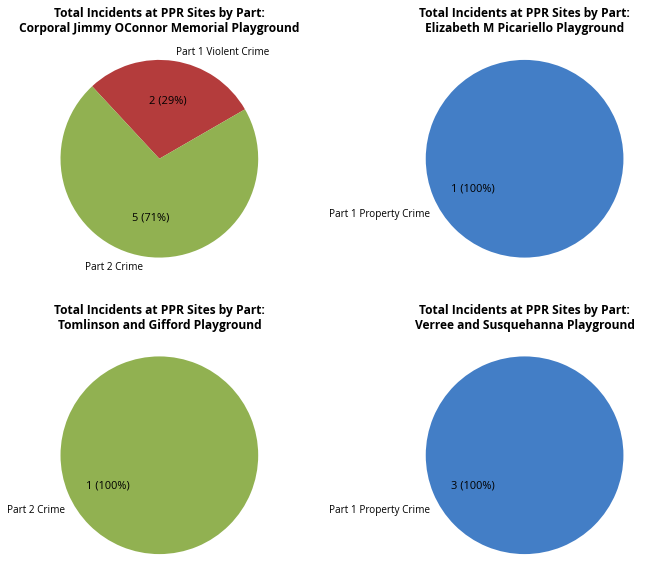

In [229]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# -- UNCOMMENT LINES BELOW IF HAVING ISSUES WITH PATH NOT BEING RECOGNIZED AND CHANGE TO CURRENT PATH -- #
#from pathlib import Path
#path = Path("X:/Projects/Special_Projects/Crime/Crime_Statistics/2021_AnnualStats_CityCouncilDistricts") #CHANGE!

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

wp = { 'linewidth' : 1}

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # CHANGE! numbers for subplots and figsize parameters

for i, (idx, row) in enumerate(dis10_sites.set_index('PUBLIC_NAME').iterrows()):
    ax = axes[i // 2, i % 2] # CHANGE! depending on subplot and figsize parameters. Can only be as big as the second numnber in the subplots parameter!
    row = row[row.gt(row.sum() * .0)]
    wedges, texts, autotexts = ax.pie(row, labels=row.index, startangle=30, autopct=lambda x: '{:.0f} ({:.0f}%)'.format((x/100)*row.sum(),x), 
           colors=[cdict[row] for row in row.index], wedgeprops = wp)
    
    plt.setp(autotexts, size = 11)
    
    ax.set_title("Total Incidents at PPR Sites by Part:\n" + str(dis10_sites['PUBLIC_NAME'][i]), weight='bold', fontname='Open Sans', fontsize='12', wrap=True)

fig.subplots_adjust(wspace=.2)

fig.savefig(str(path) + "/Districts/District10/Site_PieCharts/dis10_allsites.png", dpi=300)
plt.show()
plt.close()

#### Tables for Each Site

In [230]:
dis10_tables = sdf[sdf['COUNCIL_DISTRICT'] == '10']
# summarize incident count
dis10_tables['incident_count_new'] = sdf.groupby('GIS_CRIME')['GIS_CRIME'].transform('count')
dis10_tables = dis10_tables.groupby(['COUNCIL_DISTRICT', 'PUBLIC_NAME', 'GIS_PART', 'GIS_CRIME', 'SEASON', 'ACTIVE_HOURS']).agg({'incident_count_new': 'count'}).reset_index()
dis10_tables.head(10)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COUNCIL_DISTRICT,PUBLIC_NAME,GIS_PART,GIS_CRIME,SEASON,ACTIVE_HOURS,incident_count_new
0,10,Corporal Jimmy OConnor Memorial Playground,Part 1 Violent Crime,Aggravated Assault,Off-Season,Active,1
1,10,Corporal Jimmy OConnor Memorial Playground,Part 1 Violent Crime,Robbery,Off-Season,Non-Active,1
2,10,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,Other Sex Offenses,Off-Season,Active,1
3,10,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,Simple Assault,Off-Season,Non-Active,2
4,10,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,Vandalism,Off-Season,Non-Active,1
5,10,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,Vandalism,Summer,Active,1
6,10,Elizabeth M Picariello Playground,Part 1 Property Crime,Theft,Off-Season,Non-Active,1
7,10,Tomlinson and Gifford Playground,Part 2 Crime,Vandalism,Off-Season,Active,1
8,10,Verree and Susquehanna Playground,Part 1 Property Crime,Theft,Off-Season,Active,2
9,10,Verree and Susquehanna Playground,Part 1 Property Crime,Theft,Summer,Active,1


##### Table 1

Our first table is a pivot table that shows incident count by crime category (``GIS_CRIME``). This first cell block sets up the table, but we also want to add a total incidents row after each site for when we export individual tables for each site.

In [231]:
# create the pivot table
dis10table1 = dis10_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], aggfunc=np.sum)
dis10table1.reset_index(inplace=True)
dis10table1.head(10)

,PUBLIC_NAME,GIS_CRIME,incident_count_new
0,Corporal Jimmy OConnor Memorial Playground,Aggravated Assault,1
1,Corporal Jimmy OConnor Memorial Playground,Other Sex Offenses,1
2,Corporal Jimmy OConnor Memorial Playground,Robbery,1
3,Corporal Jimmy OConnor Memorial Playground,Simple Assault,2
4,Corporal Jimmy OConnor Memorial Playground,Vandalism,2
5,Elizabeth M Picariello Playground,Theft,1
6,Tomlinson and Gifford Playground,Vandalism,1
7,Verree and Susquehanna Playground,Theft,3


Now we need to add our totals row. We want the total of all incidents for each unique site name, so we're going to create a new column for each unique site name that is in the place of our existing site name (``PUBLIC_NAME``) column. We're doing this with a ``groupby()``, where we are essentially calculating the total for each site and then joining it back to the original table in the column of our choice.

In [232]:
# create a new dataframe to calculate the total number of incidents per site
dis10table1_sum= dis10table1.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
# create a total incidents column to store the totals in
dis10table1_sum['grand_total'] ='Total Incidents'
# preparing to ensure that this total column corresponds to the correct site name in the site name columns
dis10table1.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

# create an object for our columns from the original table
dis10table1col = dis10table1[['PUBLIC_NAME', 'GIS_CRIME', 'incident_count_new']]
# concatenate our totals dataframe to match our original dataframe's columns
dis10table1final = pd.concat([dis10table1col, dis10table1_sum])
# our totals columns 
dis10table1final = dis10table1final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
#
dis10table1final['GIS_CRIME'] =np.where(dis10table1final['grand_total'].isnull(),
                             dis10table1final['GIS_CRIME'],
                             dis10table1final['grand_total'])
# remove the total column - we no longer need it
dis10table1final.drop(['grand_total'],axis=1,inplace=True)
# fill any NA values in the table
dis10table1final.fillna(value=0, inplace=True)
# rename our columns for a more attractive table display
dis10table1final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME':'Crime Categories', 'incident_count_new': 'Incident Count'}, inplace = True)

dis10table1final.head(10)

,Site Name,Crime Categories,Incident Count
0,Corporal Jimmy OConnor Memorial Playground,Aggravated Assault,1
1,Corporal Jimmy OConnor Memorial Playground,Other Sex Offenses,1
2,Corporal Jimmy OConnor Memorial Playground,Robbery,1
3,Corporal Jimmy OConnor Memorial Playground,Simple Assault,2
4,Corporal Jimmy OConnor Memorial Playground,Vandalism,2
0,Corporal Jimmy OConnor Memorial Playground,Total Incidents,7
5,Elizabeth M Picariello Playground,Theft,1
1,Elizabeth M Picariello Playground,Total Incidents,1
6,Tomlinson and Gifford Playground,Vandalism,1
2,Tomlinson and Gifford Playground,Total Incidents,1


We now have our table with the number of incident counts per crime category, and each site now has a total incidents number tied to it as well. Now we just need to put these into a <a href="https://www.geeksforgeeks.org/python-dictionary/">dictionary</a> so that we can iterate through each site (the key value).

We will then save each unique site's table to an HTML table.

In [233]:
dict_site_10_1 = dict(iter(dis10table1final.groupby('Site Name')))
# print(dict_site_1_1) # if wanting to see 

pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_10_1: 
    with open(str(path) + '/Districts/District10/Site_Tables/'+ str(i) + '_table1' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_10_1[i].to_html(classes='mystyle')))

##### Table 2

Our second site pivot table is similar to our first, but it represents incident count by crime type (``GIS_PART``) instead. The layout and export steps are very similar to the first table.

In [234]:
# set up the pivot table
dis10table2 = dis10_tables.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_PART'], aggfunc=np.sum)
dis10table2.reset_index(inplace=True)
dis10table2.head(10)

,PUBLIC_NAME,GIS_PART,incident_count_new
0,Corporal Jimmy OConnor Memorial Playground,Part 1 Violent Crime,2
1,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,5
2,Elizabeth M Picariello Playground,Part 1 Property Crime,1
3,Tomlinson and Gifford Playground,Part 2 Crime,1
4,Verree and Susquehanna Playground,Part 1 Property Crime,3


In [235]:
# adding our sum dataframe for the totals rows and concatenating it to the original table 2 dataframe - same as before.
dis10table2_sum= dis10table2.groupby(['PUBLIC_NAME'],as_index=False)['incident_count_new'].sum() # may need to remove one of the seasons if there are no crimes in that season
dis10table2_sum['grand_total'] ='Total Incidents'
dis10table2.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

dis10table2col = dis10table2[['PUBLIC_NAME', 'GIS_PART', 'incident_count_new']]
dis10table2final = pd.concat([dis10table2col, dis10table2_sum])
dis10table2final = dis10table2final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis10table2final['GIS_PART'] =np.where(dis10table2final['grand_total'].isnull(),
                             dis10table2final['GIS_PART'],
                             dis10table2final['grand_total'])

dis10table2final.drop(['grand_total'],axis=1,inplace=True)
dis10table2final.fillna(value=0, inplace=True)
dis10table2final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_PART': 'Crime Type', 'incident_count_new': 'Incident Count'}, inplace = True)

dis10table2final.head(10)

,Site Name,Crime Type,Incident Count
0,Corporal Jimmy OConnor Memorial Playground,Part 1 Violent Crime,2
1,Corporal Jimmy OConnor Memorial Playground,Part 2 Crime,5
0,Corporal Jimmy OConnor Memorial Playground,Total Incidents,7
2,Elizabeth M Picariello Playground,Part 1 Property Crime,1
1,Elizabeth M Picariello Playground,Total Incidents,1
3,Tomlinson and Gifford Playground,Part 2 Crime,1
2,Tomlinson and Gifford Playground,Total Incidents,1
4,Verree and Susquehanna Playground,Part 1 Property Crime,3
3,Verree and Susquehanna Playground,Total Incidents,3


In [236]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_site_10_2 = dict(iter(dis10table2final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_site_10_2: 
    with open(str(path) + '/Districts/District10/Site_Tables/'+ str(i) + '_table2' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_site_10_2[i].to_html(classes='mystyle')))

##### Table 3

Our third table is a pivot table representing SUMMER incident counts by crime category (``GIS_CRIME``) broken up into active and non-active hours. 

<b>Note that if no summer crimes occurred at a site, a table WILL NOT be generated with the following cell blocks.</b>

In [237]:
dis10table3 = dis10_tables[dis10_tables['SEASON'] == 'Summer']
dis10table3 = dis10table3.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis10table3.reset_index(inplace=True)
dis10table3.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis10table3.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active
0,Corporal Jimmy OConnor Memorial Playground,Vandalism,1
1,Verree and Susquehanna Playground,Theft,1


The next steps are very similar to the first 2 site tables, but since most sites have very few summer crimes, the cell blocks for this third table may need to be modified or simply not run.

<b><font color='red'>IMPORTANT: If you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font>
    
</br>Remove only the quotation marks, the comma, and the text but not the other active hours type or the brackets. For example, ``['Active', 'Non-Active']`` becomes ``['Active']`` or ``['Non-Active']``, depending on what your error message told you.</b>

In [239]:
# adding in our dataframe for the site totals
dis10table3_sum= dis10table3.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # may need to remove one of the active hours types if there are no crimes in that season
dis10table3_sum['grand_total'] ='Total Incidents'
dis10table3.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the summer, which removed that column from the above table.<br></font></b>

In [240]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis10table3col = dis10table3[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # may need to remove one of the active hours types if there are no crimes in that season
dis10table3final = pd.concat([dis10table3col, dis10table3_sum])
dis10table3final = dis10table3final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis10table3final['GIS_CRIME'] =np.where(dis10table3final['grand_total'].isnull(),
                             dis10table3final['GIS_CRIME'],
                             dis10table3final['grand_total'])

dis10table3final.drop(['grand_total'],axis=1,inplace=True)
dis10table3final.fillna(value=0, inplace=True)
dis10table3final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Summer'}, inplace = True)

dis10table3final.head(50)

ACTIVE_HOURS,Site Name,Crime Category - Summer,Active
0,Corporal Jimmy OConnor Memorial Playground,Vandalism,1
0,Corporal Jimmy OConnor Memorial Playground,Total Incidents,1
1,Verree and Susquehanna Playground,Theft,1
1,Verree and Susquehanna Playground,Total Incidents,1


In [241]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_10_table3 = dict(iter(dis10table3final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_10_table3: 
    with open(str(path) + '/Districts/District10/Site_Tables/'+ str(i) + '_table3' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_10_table3[i].to_html(classes='mystyle')))

##### Table 4

Our fourth table is another pivot table representing the same information as table 3, but for off-season rather than summer. The process is very much the same, and the same potential warnings in the second cell block could come up.

<b>Note that if no off-season crimes occurred at a site, a table WILL NOT be generated.</b>

In [242]:
# set up our pivot table
dis10table4 = dis10_tables[dis10_tables['SEASON'] == 'Off-Season']
dis10table4 = dis10table4.pivot_table(values='incident_count_new', index=['PUBLIC_NAME', 'GIS_CRIME'], columns=['ACTIVE_HOURS'], aggfunc=np.sum)
dis10table4.reset_index(inplace=True)
dis10table4.fillna(value=0, inplace=True) # comment out if you don't want the total row for either active/non-active column to display 0 incidents
dis10table4.head(10)

ACTIVE_HOURS,PUBLIC_NAME,GIS_CRIME,Active,Non-Active
0,Corporal Jimmy OConnor Memorial Playground,Aggravated Assault,1,0
1,Corporal Jimmy OConnor Memorial Playground,Other Sex Offenses,1,0
2,Corporal Jimmy OConnor Memorial Playground,Robbery,0,1
3,Corporal Jimmy OConnor Memorial Playground,Simple Assault,0,2
4,Corporal Jimmy OConnor Memorial Playground,Vandalism,0,1
5,Elizabeth M Picariello Playground,Theft,0,1
6,Tomlinson and Gifford Playground,Vandalism,1,0
7,Verree and Susquehanna Playground,Theft,2,0


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [243]:
# add the totals for each site
dis10table4_sum= dis10table4.groupby(['PUBLIC_NAME'],as_index=False)['Active', 'Non-Active'].sum() # might need to change
dis10table4_sum['grand_total'] ='Total Incidents'
dis10table4.sort_values(by=['PUBLIC_NAME'],ascending=[True],inplace=True)

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<b><font color='red'>IMPORTANT: Again, if you get an error message like ``"Columns not found: 'Non-Active'"`` or ``"['Non-Active'] not in index"`` after running the below cell, REMOVE the type string that you are getting the error message about (either 'Active' or 'Non-Active') from the first line. This message means that no crimes of that active hours type took place in the off-season, which removed that column from the above table.<br></font></b>

In [244]:
# setting up our site totals, concatenating them to our original dataframe, and tweaking the table design
dis10table4col = dis10table4[['PUBLIC_NAME', 'GIS_CRIME', 'Active', 'Non-Active']] # might need to change
dis10table4final = pd.concat([dis10table4col, dis10table4_sum])
dis10table4final = dis10table4final.sort_values(by=['PUBLIC_NAME','grand_total'],ascending=[True,True],na_position='first')
dis10table4final['GIS_CRIME'] =np.where(dis10table4final['grand_total'].isnull(),
                             dis10table4final['GIS_CRIME'],
                             dis10table4final['grand_total'])

dis10table4final.drop(['grand_total'],axis=1,inplace=True)
dis10table4final.fillna(value=0, inplace=True)
dis10table4final.rename(columns = {'PUBLIC_NAME': 'Site Name', 'GIS_CRIME': 'Crime Category - Off-Season'}, inplace = True)

dis10table4final.head(10)

ACTIVE_HOURS,Site Name,Crime Category - Off-Season,Active,Non-Active
0,Corporal Jimmy OConnor Memorial Playground,Aggravated Assault,1,0
1,Corporal Jimmy OConnor Memorial Playground,Other Sex Offenses,1,0
2,Corporal Jimmy OConnor Memorial Playground,Robbery,0,1
3,Corporal Jimmy OConnor Memorial Playground,Simple Assault,0,2
4,Corporal Jimmy OConnor Memorial Playground,Vandalism,0,1
0,Corporal Jimmy OConnor Memorial Playground,Total Incidents,2,4
5,Elizabeth M Picariello Playground,Theft,0,1
1,Elizabeth M Picariello Playground,Total Incidents,0,1
6,Tomlinson and Gifford Playground,Vandalism,1,0
2,Tomlinson and Gifford Playground,Total Incidents,1,0


In [245]:
# saving our table to a dictionary so each key (or site) will be saved separately)
dict_10_table4 = dict(iter(dis10table4final.groupby('Site Name')))

# saving to HTMLs using our CSS stylesheet
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <link rel="stylesheet" type="text/css" href="X:/Projects/Special_Projects/Crime/Crime_Statistics/2022_01_GIS_Automation_Testing/css/table.css"/>
  <body>
    {table}
  </body>
</html>.
'''
for i in dict_10_table4: 
    with open(str(path) + '/Districts/District10/Site_Tables/'+ str(i) + '_table4' + '.html', 'w') as f:
        f.write(html_string.format(table=dict_10_table4[i].to_html(classes='mystyle')))

## Pie Charts for the 10 District Overview Pages 

By running the District Pie Chart subsections for each of the district sections above, you created 10 unique pie chart dataframes. We'll now compile those into a list so that we can create all 10 district pie charts (to be displayed on each district's overview page) at once. 

Note that this code is still in progress. The goal is to produce each pie chart to save as a separate PNG.

In [246]:
dispies = [dis1pie, dis2pie, dis3pie, dis4pie, dis5pie, dis6pie, dis7pie, dis8pie,
       dis9pie, dis10pie]

<b>If the labels of the pie chart slices overlap one another and it's difficult to read the pie chart, you can change the explode wedge property values (marked below in the code with a #CHANGE! comment at the end of the line) so that the pie chart slices and their labels are "exploded," or further away from one another.
    
Changing these numbers to be larger will set the wedges further apart. The numbers are ordered the same as the ``GIS_PART``'s alphabetical ordering, which is 1. Part 1 Property Crime as the first number, 2. Part 1 Violent Crime as the second number, and 3. Part 2 Crime as the third number.</b>

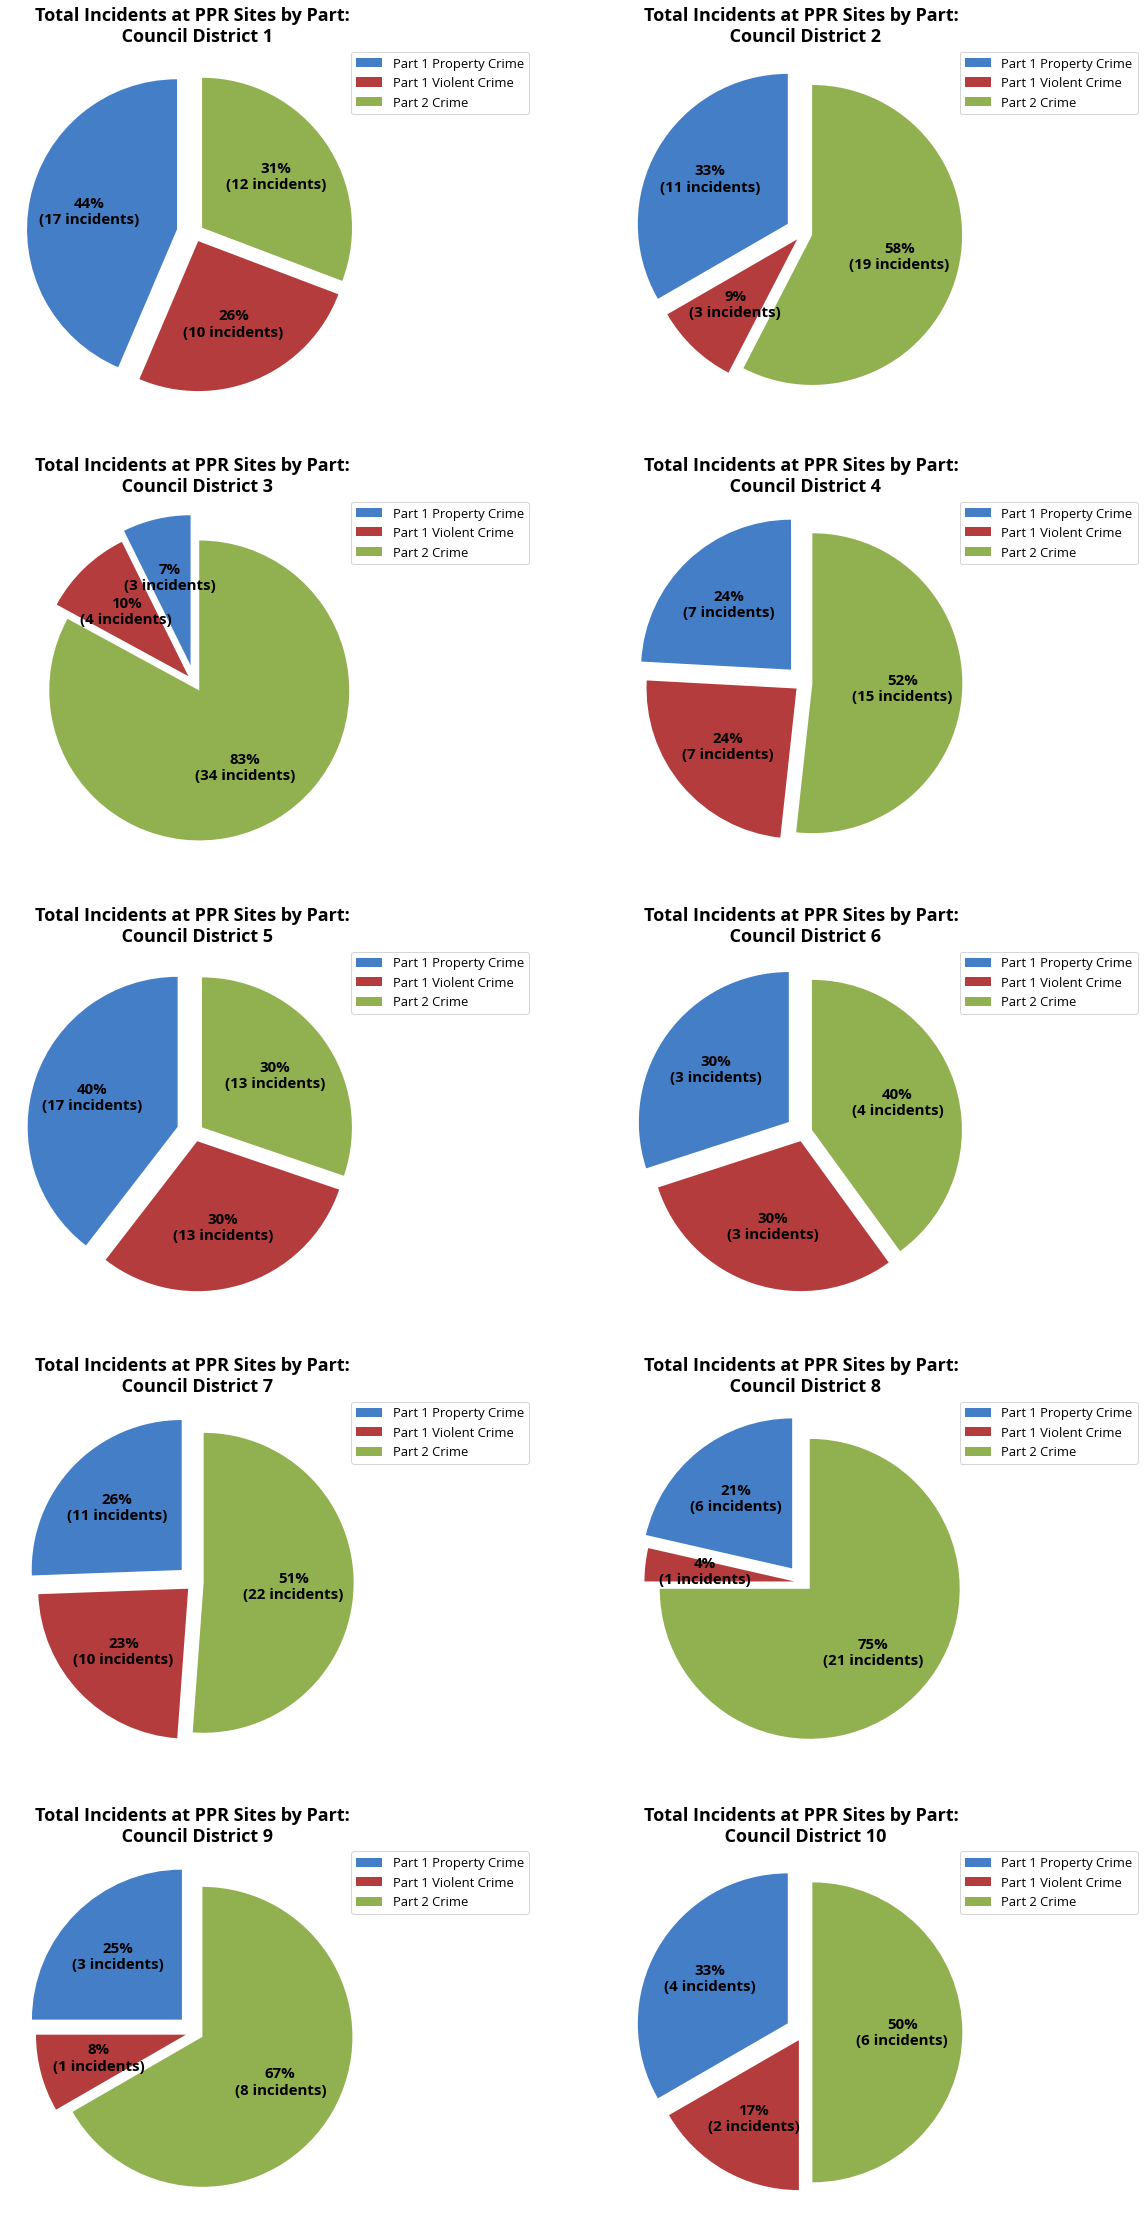

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

KeyError: 3

In [247]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['font.family'] = "sans-serif"
    
# Creating color parameters
colors = ("#437EC6", "#B43C3C", "#91B151")
 
# Wedge properties
wp = { 'linewidth' : 1}
explode = 0.12, 0.06, 0.06 # CHANGE! IF LABELS ARE OVERLAPPING - this determines how far away the wedges for the different crime parts are from one another
 
# Creating autocpt arguments
for i, dispie in enumerate(dispies):
    def autopct_format(values):
        def my_format(pct):
            total=sum(values)
            val=int(round(pct*total/100.0))
            return '{:.0f}%\n({v:d} incidents)'.format(pct, v=val)
        return my_format # creates labels text - % and # of incidents
 
# Creating plot

fig, axs = plt.subplots(5,2)
ax = axs.ravel()

for i, dispie in enumerate(dispies):
    wedges, texts, autotexts = ax[i].pie(dispie['incident_count'],
                                  autopct = autopct_format(dispie['incident_count']),
                                  colors = colors,
                                  startangle = 90,
                                  #shadow = True,
                                  explode = explode,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
    plt.setp(autotexts, size = 15, weight ="bold")
 
# Adding legend

for i, dispie in enumerate(dispies):
    ax[i].legend(wedges, dispie['GIS_PART'],
        loc ="upper left",
        fontsize = 13,
        bbox_to_anchor =(0.9, 0, 0.5, 1))

for i, dispie in enumerate(dispies):
    ax[i].set_title("Total Incidents at PPR Sites by Part: \n Council District " 
                    + str(dispie['COUNCIL_DISTRICT'][1]), weight='bold', 
                    fontname='Open Sans', fontsize='18', wrap=True)
 
# show and save plot

outpath = r"X:\Projects\Special_Projects\Crime\Crime_Statistics\2021_AnnualStats_CityCouncilDistricts\Districts\DistrictPies"
fig.set_size_inches(20, 40)
for i, dispie in enumerate(dispies):
    extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(path.join(outpath, "dispie_{}.png".format(dispies[i].COUNCIL_DISTRICT[i], dpi=300)))
    plt.show()